# 多臂老虎机

# 0. 一些初始化

## 0.1 题目设定的程序

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

In [14]:
max([np.random.rand() for i in range(100)])

0.9957229713717768

随机生成了一个10臂伯努利老虎机
获得概率最大的拉杆为6号，其获奖概率为0.8974


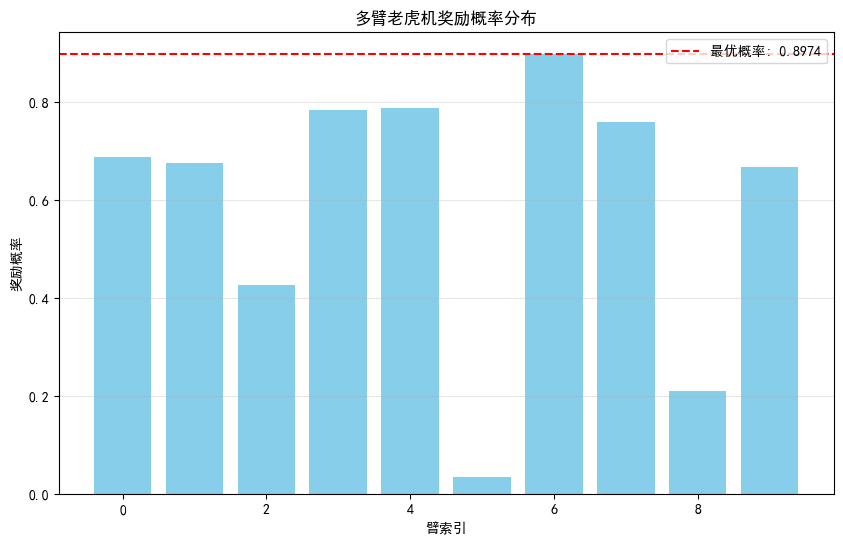

In [93]:
class BernoulliBandit:
    """
    伯努利多臂老虎机
    
    参数:
        K (int): 老虎机的臂(拉杆)数量
        seed (int, optional): 随机种子，用于结果复现
    
    属性:
        probs (np.ndarray): 每个臂的奖励概率(0-1之间的值)
        best_idx (int): 最优臂的索引
        best_prob (float): 最优臂的奖励概率
        K (int): 臂的数量
        counts (np.ndarray): 每个臂被选择的次数
        values (np.ndarray): 每个臂的平均奖励值
        cumulative_regret (float): 累积遗憾
        cumulative_reward (float): 累积奖励
        history (list): 历史选择记录(臂索引, 奖励)
    """
    
    def __init__(self, K, seed=None):
        """
        初始化伯努利多臂老虎机
        
        参数:
            K (int): 臂的数量
            seed (int, optional): 随机种子
        """
        if seed is not None:
            np.random.seed(seed)
            
        self.probs = np.random.uniform(size=K)       # 随机生成K个0~1的数，作为拉动每根拉杆的获得奖励的概率
        self.best_idx = np.argmax(self.probs)        # 获奖概率最大的拉杆索引
        self.best_prob = self.probs[self.best_idx]   # 最大的奖励概率
        self.K = K
        
        # 初始化统计信息
        self.counts = np.zeros(K, dtype=int)         # 每个臂被选择的次数
        self.values = np.zeros(K)                    # 每个臂的平均奖励值
        self.cumulative_regret = 0.0                # 累积遗憾
        self.cumulative_reward = 0.0                # 累积奖励
        self.history = []                            # 历史选择记录(臂索引, 奖励)

    def step(self, k):
        """
        选择指定的臂并返回奖励
        
        参数:
            k (int): 选择的臂索引(0到K-1)
        
        返回:
            reward (int): 奖励值(0或1)
        """
        # 检查输入有效性
        if k < 0 or k >= self.K:
            raise ValueError(f"臂索引{k}超出范围(0-{self.K-1})")
        
        # 生成奖励(伯努利试验)
        reward = 1 if np.random.rand() < self.probs[k] else 0
        
        # 更新统计信息
        self.counts[k] += 1
        # 使用增量公式更新平均值: new_avg = old_avg + (reward - old_avg) / count
        self.values[k] += (reward - self.values[k]) / self.counts[k]
        
        # 更新累积奖励和遗憾
        self.cumulative_reward += reward
        self.cumulative_regret += self.best_prob - reward
        
        # 记录历史
        self.history.append((k, reward))
        
        return reward
    
    def reset_stats(self):
        """重置所有统计信息(保持概率分布不变)"""
        self.counts = np.zeros(self.K, dtype=int)
        self.values = np.zeros(self.K)
        self.cumulative_regret = 0.0
        self.cumulative_reward = 0.0
        self.history = []
    
    def plot_probabilities(self):
        """可视化每个臂的奖励概率"""
        plt.figure(figsize=(10, 6))
        plt.bar(range(self.K), self.probs, color='skyblue')
        plt.axhline(y=self.best_prob, color='r', linestyle='--', label=f'最优概率: {self.best_prob:.4f}')
        plt.xlabel('臂索引')
        plt.ylabel('奖励概率')
        plt.title('多臂老虎机奖励概率分布')
        plt.legend()
        plt.grid(True, axis='y', alpha=0.3)
        plt.show()
    
    def plot_performance(self):
        """可视化老虎机的性能指标"""
        if not self.history:
            print("没有历史数据可供绘图")
            return
        
        # 准备数据
        steps = np.arange(1, len(self.history) + 1)
        rewards = np.array([r for _, r in self.history])
        cumulative_rewards = np.cumsum(rewards)
        cumulative_regrets = np.cumsum([self.best_prob - r for r in rewards])
        
        # 创建图表
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        
        # 累积奖励图
        ax1.plot(steps, cumulative_rewards, label='累积奖励')
        ax1.plot(steps, self.best_prob * steps, 'r--', label='理论最大奖励')
        ax1.set_title('累积奖励随时间变化')
        ax1.set_ylabel('累积奖励')
        ax1.legend()
        ax1.grid(True)
        
        # 累积遗憾图
        ax2.plot(steps, cumulative_regrets, label='累积遗憾')
        ax2.set_title('累积遗憾随时间变化')
        ax2.set_xlabel('步数')
        ax2.set_ylabel('累积遗憾')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def __str__(self):
        """返回老虎机的字符串表示"""
        return (f"BernoulliBandit(K={self.K}, best_arm={self.best_idx}, "
                f"best_prob={self.best_prob:.4f})")

    def report_all(self):
        # 输出统计信息
        print(f"\n累积奖励: {self.cumulative_reward}")
        print(f"累积遗憾: {self.cumulative_regret:.2f}")
        results_df = pd.DataFrame({
            '臂编号': range(1, len(self.counts) + 1),
            '选择次数': self.counts,
            '奖励概率': np.round(self.probs, 4),
            '平均奖励': np.round(self.values, 4)
        })
        
        print("多臂老虎机统计结果:")
        print(results_df.to_string(index=False))
        
        # 可视化性能
        self.plot_performance()
        
# 测试代码
if __name__ == "__main__":
    np.random.seed(114514)
    K = 10
    bandit = BernoulliBandit(K)
    print("随机生成了一个10臂伯努利老虎机")
    print(f"获得概率最大的拉杆为{bandit.best_idx}号，其获奖概率为{bandit.best_prob:.4f}")
    
    # 可视化概率分布
    bandit.plot_probabilities()
    
    # 模拟随机选择策略，用于了解环境运行，交互次数为200次，累计奖励
    # print("\n模拟随机选择策略...")
    # for _ in range(200):
    #     arm = np.random.randint(K)  # 随机选择一个臂
    #     reward = bandit.step(arm)
    
    #====================================#
    #你的代码，需将前面的随机策略注释
   
    #====================================#
    
    
    

## 0.2 构造多轮测试程序

由于每次测试存在随机性，因此一个算法需要经过多轮测试以观察其平均表现与鲁棒性，因此需要造个函数来测试每种策略，设定对每种算法进行<span style = 'color:red'>**十万轮**</span>测试，每轮就是题目设定的200步长的拉杆，然后所有轮结果的均值和标准差来看这个策略的平均表现和稳定性。

In [221]:
# 原版AI写的，画图程序ai写的一般都比我好，后续又自己根据需求进行了改进
def test_strategy(strategy_func, test_iter= 100000, anomalous_threshold=50):
    '''
    多轮测试策略函数的效果，返回平均累积奖励和遗憾
    '''
    
    total_rewards = []
    total_regrets = []
    anomalous_cases = [] # 将regret大于某个阈值的异常bandit保存以便后续研究

    for _ in range(test_iter):
        bandit = BernoulliBandit(10)
        bandit.reset_stats()  # 重置统计信息
        bandit = strategy_func(bandit, 200)
        total_rewards.append(bandit.cumulative_reward)
        total_regrets.append(bandit.cumulative_regret)
        if bandit.cumulative_regret > anomalous_threshold: # 设定一个阈值，比如20
            anomalous_cases.append(copy.deepcopy(bandit))

    # 创建两个图表
    plt.figure(figsize=(12, 5))
    
    # 第一个子图：趋势图
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(test_iter), total_rewards, label='累积奖励', color='blue', linewidth=2)
    plt.plot(np.arange(test_iter), total_regrets, label='累积遗憾', color='red', linewidth=2)
    plt.xlabel('测试轮数')
    plt.ylabel('数值')
    plt.title('累积奖励和遗憾趋势')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 第二个子图：遗憾箱线图
    plt.subplot(1, 2, 2)
    plt.boxplot(total_regrets, patch_artist=True,
               boxprops=dict(facecolor='lightcoral', color='red'),
               medianprops=dict(color='darkred', linewidth=2),
               whiskerprops=dict(color='red'),
               capprops=dict(color='red'),
               flierprops=dict(marker='o', color='red', alpha=0.5))
    plt.xticks([1], ['累积遗憾'])
    plt.ylabel('遗憾值')
    plt.title('累积遗憾分布箱线图')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print(f"平均累积奖励: {np.mean(total_rewards):.2f}, 平均累积遗憾: {np.mean(total_regrets):.2f}")
    print(f"标准差(奖励): {np.std(total_rewards):.2f}, 标准差(遗憾): {np.std(total_regrets):.2f}")
    print(f"累积遗憾统计:")
    print(f"  最小值: {np.min(total_regrets):.2f}, 最大值: {np.max(total_regrets):.2f}")
    print(f"  25%分位数: {np.percentile(total_regrets, 25):.2f}")
    print(f"  中位数: {np.median(total_regrets):.2f}")
    print(f"  75%分位数: {np.percentile(total_regrets, 75):.2f}")
    
    return anomalous_cases

## 0.3 规律探索

先通过一些实验来看看我们的算法需要面对哪些情况

首先，我们初始化一个多臂老虎机，对每个拉杆都拉200回，画出各拉杆平均奖励值（样本概率）随拉动次数变化的图像，观察不同真实奖励概率的拉杆的样本概率随拉动次数变化情况

In [173]:
def experiment_1(num_arms, num_steps= 200, preset_probs=None):
    '''
    每个拉杆都拉200回，画出各拉杆平均奖励值（样本概率）随拉动次数变化的图像
    '''
    data = {i: [] for i in range(num_arms)}
    test_bandit = BernoulliBandit(num_arms)
    if preset_probs:
        test_bandit.probs = np.array(preset_probs)
        test_bandit.best_idx = np.argmax(test_bandit.probs)        # 获奖概率最大的拉杆索引
        test_bandit.best_prob = test_bandit.probs[test_bandit.best_idx]   # 最大的奖励概率
    for k in range(num_arms):
        for i in range(num_steps):
            test_bandit.step(k)
            data[k].append(np.round(test_bandit.values[k], 4))
    data_df = pd.DataFrame(data)
    data_df.plot(figsize=(12, 6), alpha=1)
    plt.title('各拉杆平均奖励值（样本概率）随拉动次数变化')
    return data_df, test_bandit

用上述函数得到以下几种情况

- 最大概率臂（绿）第一次奖励为0但迅速回升到属于它的位置
![T1_p1](RL_answer\T1_p1.png)

- 最大概率臂（红）第一次奖励为1并在跌落后迅速回升到属于它的位置
![T1_p2](RL_answer\T1_p2.png)

接着，我们想研究一下不同真实概率的拉杆连续获得奖励次数（连续奖励次数大于等于2）的情况

首先一个简单的数学问题，伯努利实验中连续成功的概率为：

$$
\begin{align}
P(连续成功x次) = p^x
\end{align}
$$

那么$p$越小，连续很多次成功的概率就越小，同样，若是一个拉杆连续获得奖励了很多次，那它的真实概率也不会很小

我们先造一个用来验证的代码函数 experiment_2, 其可以调整拉杆的数量和每个拉杆拉多少次

In [ ]:
# AI基于写的代码改进结果
def experiment_2(num_arms, num_steps=200, preset_probs=None):
    '''
    每个拉杆都拉200回，画出各拉杆超过2次连续获得奖励次数的分布箱线图
    '''
    data = {i: [] for i in range(num_arms)}
    test_bandit = BernoulliBandit(num_arms)
    if preset_probs:
        test_bandit.probs = np.array(preset_probs)
        test_bandit.best_idx = np.argmax(test_bandit.probs)        # 获奖概率最大的拉杆索引
        test_bandit.best_prob = test_bandit.probs[test_bandit.best_idx]   # 最大的奖励概率
    
    for k in range(num_arms):
        multiple_reward_count = 0
        for i in range(num_steps):
            reward = test_bandit.step(k)
            if reward == 1:
                multiple_reward_count += 1
            else:
                if multiple_reward_count > 1:  # 只记录连续奖励次数大于1的情况
                    data[k].append(multiple_reward_count)
                multiple_reward_count = 0
        
        # 处理最后一次连续奖励的情况（如果以连续奖励结束）
        if multiple_reward_count > 1:
            data[k].append(multiple_reward_count)
    
    # 创建箱线图
    plt.figure(figsize=(12, 8))
    
    # 准备箱线图数据
    box_data = [data[i] for i in range(num_arms) if data[i]]  # 过滤空列表
    labels = [f'拉杆 {i+1}\n(p={test_bandit.probs[i]:.2f})' for i in range(num_arms) if data[i]]
    
    # 绘制箱线图
    box_plot = plt.boxplot(box_data, labels=labels, patch_artist=True)
    
    # 美化箱线图
    colors = plt.cm.Set3(np.linspace(0, 1, num_arms))
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    plt.title('各拉杆连续获得奖励次数的箱线图', fontsize=14, fontweight='bold')
    plt.xlabel('拉杆编号 (对应概率)', fontsize=12)
    plt.ylabel('连续获得奖励的次数', fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    
    # 添加统计信息标注
    for i, arm_data in enumerate(box_data):
        if arm_data:  # 确保数据不为空
            median_val = np.median(arm_data)
            mean_val = np.mean(arm_data)
            plt.text(i+1, max(arm_data) + 0.2, f'中位数: {median_val:.1f}', 
                    ha='center', va='bottom', fontsize=9, color='red')
    
    plt.tight_layout()
    plt.show()
    
    # 创建DataFrame用于返回
    max_len = max(len(data[i]) for i in range(num_arms))
    data_dict = {}
    for i in range(num_arms):
        padded_data = data[i] + [np.nan] * (max_len - len(data[i]))
        data_dict[f'arm_{i+1}'] = padded_data
    
    data_df = pd.DataFrame(data_dict)
    
    # 打印基本统计信息
    print("各拉杆连续奖励次数的统计信息:")
    print("=" * 50)
    for i in range(num_arms):
        if data[i]:
            print(f"拉杆 {i+1} (p={test_bandit.probs[i]:.2f}): "
                  f"次数={len(data[i])}, 均值={np.mean(data[i]):.2f}, "
                  f"中位数={np.median(data[i]):.1f}, 最大值={max(data[i])}")
        else:
            print(f"拉杆 {i+1} (p={test_bandit.probs[i]:.2f}): 无连续奖励记录")
    
    return data_df, test_bandit

# 使用示例
# data_df, bandit = experiment_2(5, preset_probs=[0.1, 0.3, 0.5, 0.7, 0.9])

我们设置10个拉杆，其真实奖励概率分别设定为[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]， 每个拉杆拉200次，结果如下

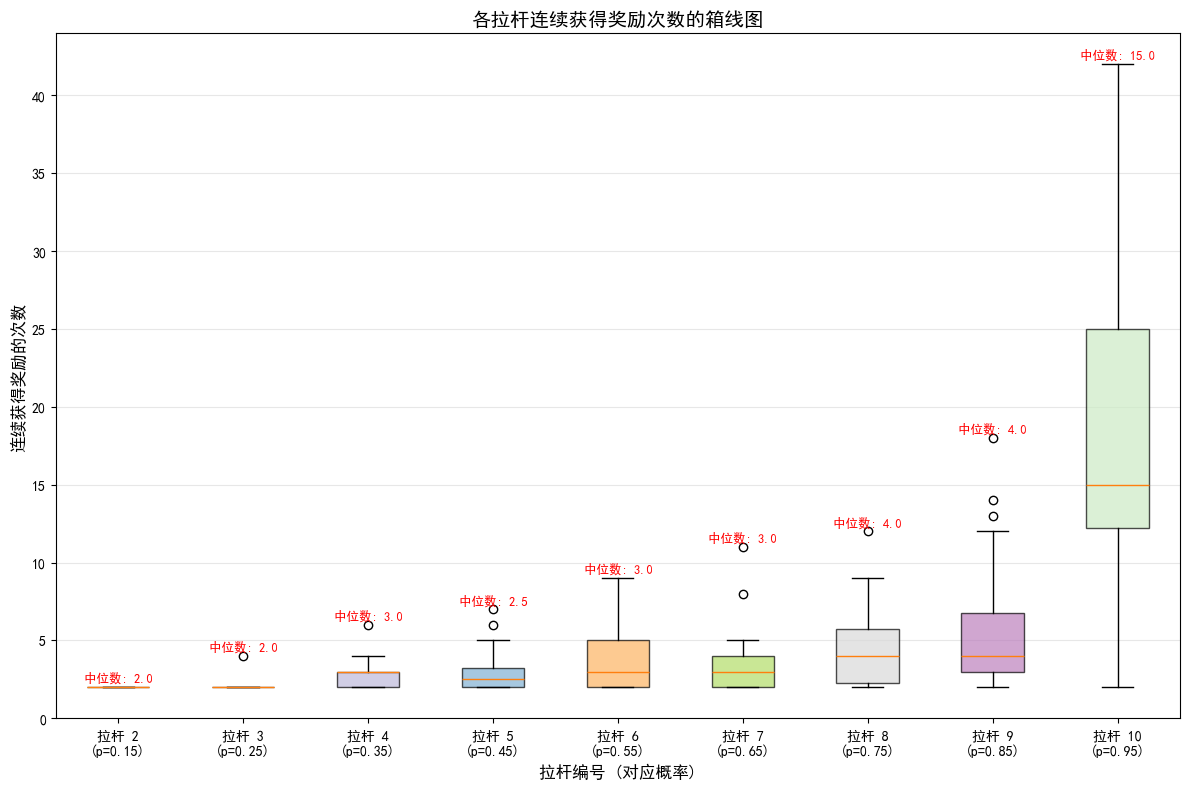

各拉杆连续奖励次数的统计信息:
拉杆 1 (p=0.05): 无连续奖励记录
拉杆 2 (p=0.15): 次数=3, 均值=2.00, 中位数=2.0, 最大值=2
拉杆 3 (p=0.25): 次数=12, 均值=2.17, 中位数=2.0, 最大值=4
拉杆 4 (p=0.35): 次数=15, 均值=2.80, 中位数=3.0, 最大值=6
拉杆 5 (p=0.45): 次数=24, 均值=3.00, 中位数=2.5, 最大值=7
拉杆 6 (p=0.55): 次数=26, 均值=3.54, 中位数=3.0, 最大值=9
拉杆 7 (p=0.65): 次数=29, 均值=3.59, 中位数=3.0, 最大值=11
拉杆 8 (p=0.75): 次数=26, 均值=4.54, 中位数=4.0, 最大值=12
拉杆 9 (p=0.85): 次数=26, 均值=5.62, 中位数=4.0, 最大值=18
拉杆 10 (p=0.95): 次数=10, 均值=18.90, 中位数=15.0, 最大值=42


(    arm_1  arm_2  arm_3  arm_4  arm_5  arm_6  arm_7  arm_8  arm_9  arm_10
 0     NaN    2.0    2.0    4.0    2.0    9.0      2    4.0    4.0     5.0
 1     NaN    2.0    4.0    3.0    3.0    7.0      5   12.0    6.0    17.0
 2     NaN    2.0    2.0    3.0    2.0    3.0      2    2.0    5.0    35.0
 3     NaN    NaN    2.0    2.0    2.0    2.0      2    8.0   14.0    25.0
 4     NaN    NaN    2.0    2.0    2.0    2.0     11    4.0    3.0    12.0
 5     NaN    NaN    2.0    6.0    2.0    2.0      8    7.0    3.0    25.0
 6     NaN    NaN    2.0    3.0    5.0    2.0      4    3.0    4.0    13.0
 7     NaN    NaN    2.0    3.0    2.0    2.0      2    3.0    3.0    42.0
 8     NaN    NaN    2.0    2.0    2.0    3.0      5    2.0    4.0     2.0
 9     NaN    NaN    2.0    3.0    3.0    3.0      4    2.0    2.0    13.0
 10    NaN    NaN    2.0    2.0    7.0    2.0      5    5.0    3.0     NaN
 11    NaN    NaN    2.0    3.0    3.0    6.0      2    3.0    2.0     NaN
 12    NaN    NaN    NaN 

In [206]:
experiment_2(10, preset_probs=[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

**可以看出，当每个拉杆拉得足够多时，真实奖励概率越高的拉杆，其连续奖励次数的中位数和均值越大**

但我们的问题里条件不是这样的，实际问题是所有拉杆被拉的次数总和为200次，我们在此期间需要找到最优的那个拉杆，所以部分拉杆必定面临拉动次数较少的问题，那么让我们来看看拉动次数少的时候刚刚发现的规律是否还显著：

我们用同样的拉杆总数和预设概率，只是每个拉杆的拉动次数改为5

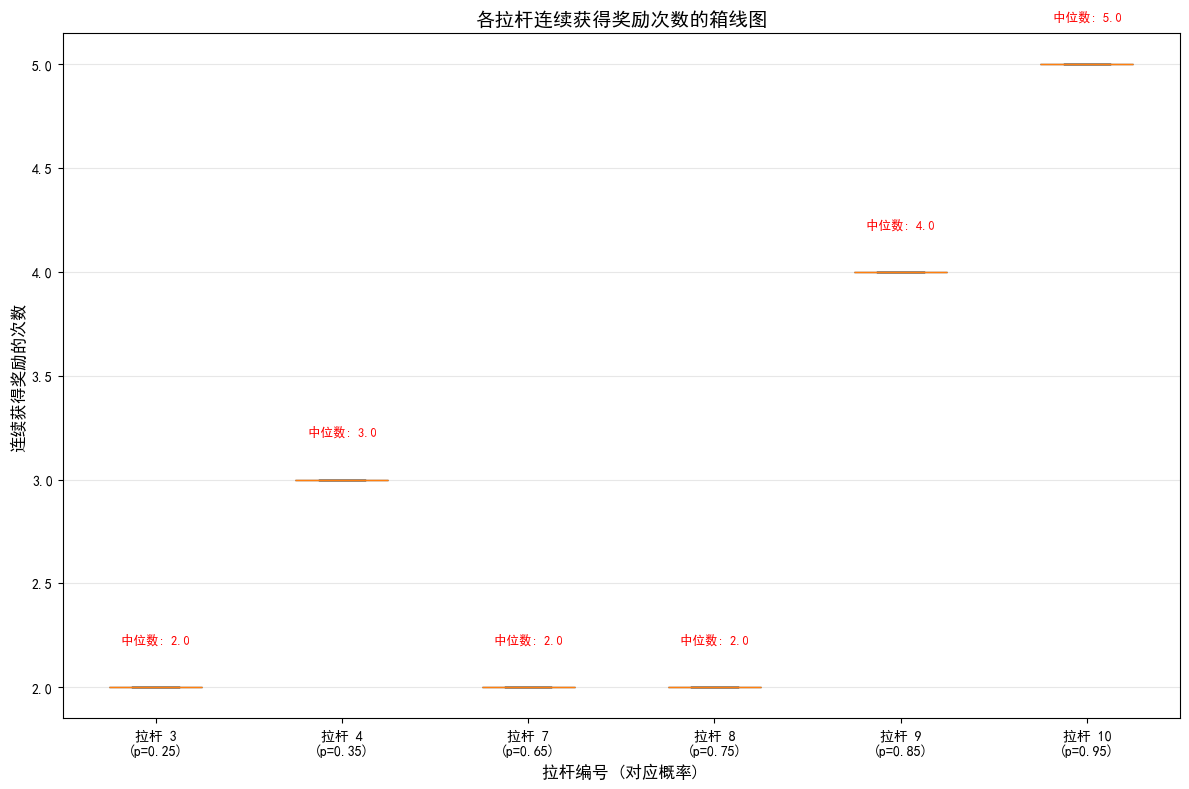

各拉杆连续奖励次数的统计信息:
拉杆 1 (p=0.05): 无连续奖励记录
拉杆 2 (p=0.15): 无连续奖励记录
拉杆 3 (p=0.25): 次数=1, 均值=2.00, 中位数=2.0, 最大值=2
拉杆 4 (p=0.35): 次数=1, 均值=3.00, 中位数=3.0, 最大值=3
拉杆 5 (p=0.45): 无连续奖励记录
拉杆 6 (p=0.55): 无连续奖励记录
拉杆 7 (p=0.65): 次数=1, 均值=2.00, 中位数=2.0, 最大值=2
拉杆 8 (p=0.75): 次数=2, 均值=2.00, 中位数=2.0, 最大值=2
拉杆 9 (p=0.85): 次数=1, 均值=4.00, 中位数=4.0, 最大值=4
拉杆 10 (p=0.95): 次数=1, 均值=5.00, 中位数=5.0, 最大值=5


(   arm_1  arm_2  arm_3  arm_4  arm_5  arm_6  arm_7  arm_8  arm_9  arm_10
 0    NaN    NaN    2.0    3.0    NaN    NaN    2.0      2    4.0     5.0
 1    NaN    NaN    NaN    NaN    NaN    NaN    NaN      2    NaN     NaN,
 <__main__.BernoulliBandit at 0x201f73d3140>)

In [211]:
experiment_2(10, preset_probs=[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95], num_steps=5)

可以看出，一些真实奖励概率较小的拉杆根本没有超过2次以上的连续奖励，而有一些真实奖励概率较小的拉杆（4号）表现甚至优于真实概率比它大的拉杆（7、8号），而概率最大的拉杆仍然有最高的连续奖励次数。所以当抽样次数不充分时，这个规律只能对真实概率极端大或极端小的拉杆有效。

# 0.4 问题假设

我们对问题情景做出以下假设：
- 多臂老虎机的使用者并不知晓任何关于真实奖励概率的信息，包括累计遗憾，因为这个统计量在计算时涉及了最大奖励真实概率值

# 1. 方案A 正反馈消退算法

算法的底层逻辑，简单来说，就是一直有正反馈就一直拉这个拉杆，一旦没有奖励了就重新选一个拉杆，以此往复直至200次。当然这个要是展开说一说就是行为主义心理学里的一个概念：消退（Extinction），意思是当一个被强化的行为不再得到任何强化（无论是正强化还是负强化）时，该行为发生的频率就会逐渐下降直至消失，人的耐心确实是有限的，所以这个理论有一定道理。这种概念性的东西多展开介绍一下放在论文里既能水字数又能读着有点新鲜感，不过这种玩概念的小打小闹式创新搞多了学术生涯就废了。


言归正传，这种算法的关键在于，拉一个拉杆没得到奖励后怎么决定重新选哪一个拉杆呢？我们就此问题来一步步优化

## 1.1 Ver.1 消退后随机选拉杆

最简单的，没得到奖励就随机重新选一个拉杆

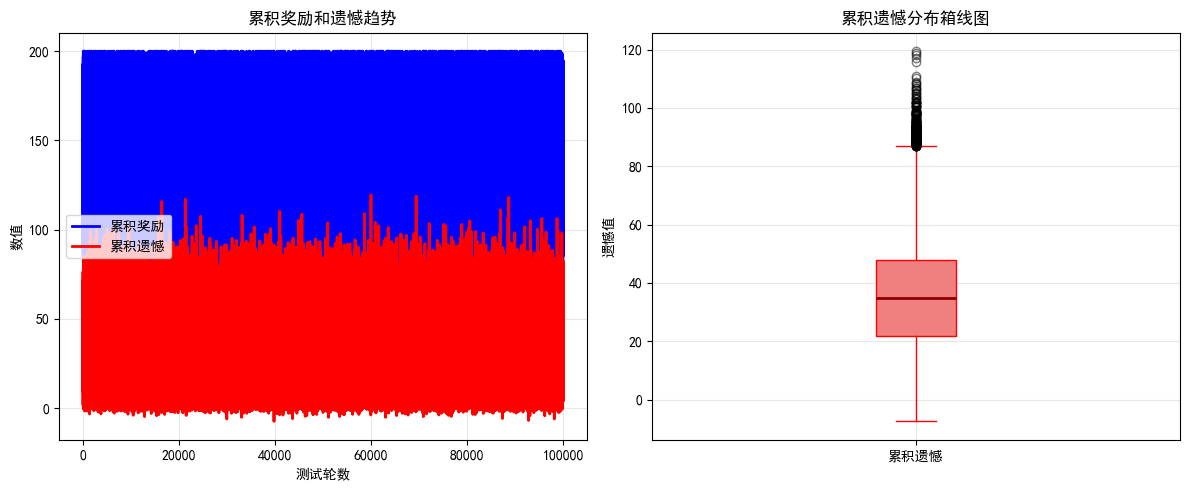

平均累积奖励: 146.61, 平均累积遗憾: 35.24
标准差(奖励): 29.98, 标准差(遗憾): 18.41
累积遗憾统计:
  最小值: -7.47, 最大值: 119.46
  25%分位数: 21.73
  中位数: 34.81
  75%分位数: 47.83


In [222]:
def extinction_player(bandit: object, iter_num: int) -> object:
    '''
    正反馈消退算法,消退后随机选拉杆

    :param: bandit: 初始化好的老虎机
    :param: iter_num： 总共要拉多少次

    '''
    bandit_copy = copy.deepcopy(bandit)
    K = bandit_copy.K
    reward = 0
    for _ in range(iter_num):
        if not reward:
            k = np.random.randint(K)
        reward = bandit_copy.step(k)

    return bandit_copy

test_res_ep1 = test_strategy(extinction_player)

## 1.2 Ver.2 消退后基于样本概率选拉杆

策略：

- 当不是所有拉杆都试过一遍前，每次重新选拉杆时还是随机选；
- 当所有拉杆都试过一遍后，选样本概率最大的那个拉杆

即使因为样本量较少，部分拉杆的样本概率和真实概率有出入，但根据大数定律，策略最后还是能找到实际概率最大的那个拉杆，只过是时间问题

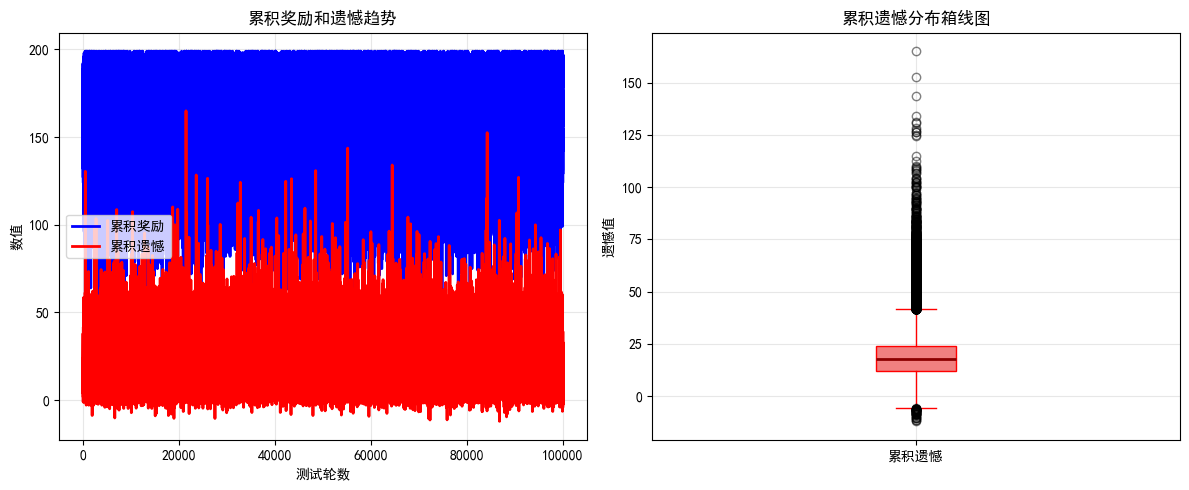

平均累积奖励: 162.13, 平均累积遗憾: 18.84
标准差(奖励): 20.39, 标准差(遗憾): 10.76
累积遗憾统计:
  最小值: -12.06, 最大值: 165.00
  25%分位数: 12.07
  中位数: 17.53
  75%分位数: 23.93


In [224]:

def extinction_player_v2(bandit: object, iter_num: int) -> object:
    '''
    正反馈消退算法，消退后基于样本概率选拉杆

    :param: bandit: 初始化好的老虎机
    :param: iter_num： 总共要拉多少次

    '''
    bandit_copy = copy.deepcopy(bandit)
    K = bandit_copy.K
    reward = 0
    k = np.random.randint(K)  # 初始化k为随机拉杆
    for _ in range(1, iter_num):
        if not reward:
            if 0 in bandit_copy.counts:
                k = np.random.choice([i for i in range(K) if i != k])
            else:
                k = bandit_copy.values.argmax()
        reward = bandit_copy.step(k)
        
    return bandit_copy

test_res_ep2 = test_strategy(extinction_player_v2)

可以看出v2的表现比v1要好，但稳定性差不多（标准差）

## 1.3 Ver.3 加入大数定律的限制

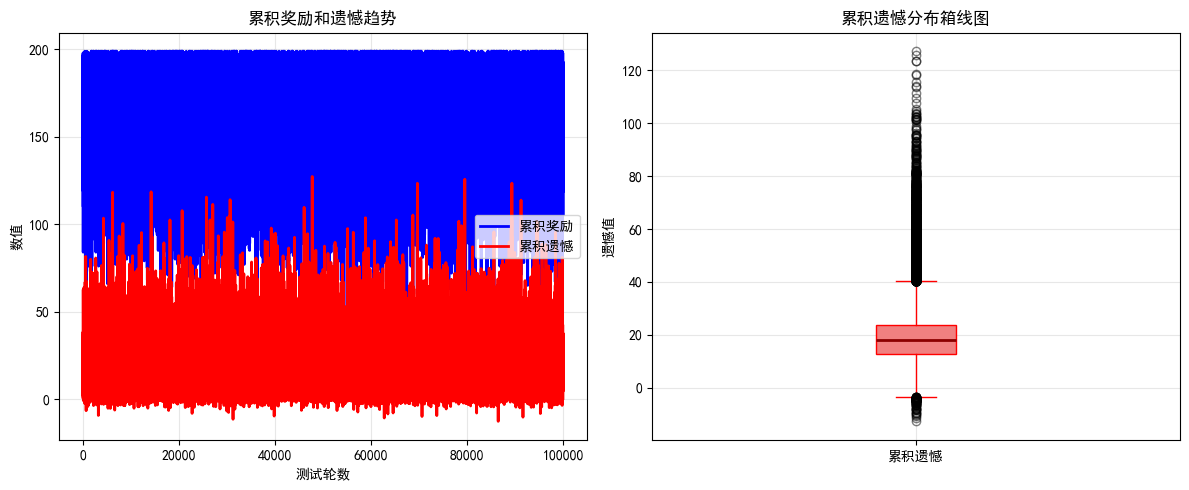

平均累积奖励: 162.04, 平均累积遗憾: 18.88
标准差(奖励): 20.04, 标准差(遗憾): 10.09
累积遗憾统计:
  最小值: -12.78, 最大值: 127.31
  25%分位数: 12.78
  中位数: 18.05
  75%分位数: 23.75


In [225]:
def extinction_player_v3(bandit: object, iter_num: int, verbose: bool = False) -> object:
    '''
    正反馈消退算法，消退后基于样本概率选拉杆，但是要顾及大数定律，然后打擂台赛

    :param: bandit: 初始化好的老虎机
    :param: iter_num： 总共要拉多少次

    '''
    bandit_copy = copy.deepcopy(bandit)
    K = bandit_copy.K
    reward = 0
    k = np.random.randint(K)  # 初始化k为随机拉杆
    success_counts = np.array([0]*K)  # 成功次数
    fail_counts = np.array([0]*K)     # 失败次数
    candidate_arms_mask = np.array([1]*K) # 可能的最优臂集合
    ring = [] # 擂台
    for _ in range(1, iter_num):
        if not reward:
            if 0 in bandit_copy.counts: # 如果还有一次都没有拉过的拉杆
                k = np.random.choice(np.where(candidate_arms_mask == 1)[0])
            else:
                # k = np.argmax(np.array(bandit_copy.values)*candidate_arms_mask)
                k = np.argmax(bandit_copy.values)
            # k = np.random.choice(np.where(candidate_arms_mask == 1)[0])
        reward = bandit_copy.step(k)
        success_counts[k] += reward
        fail_counts[k] += (1 - reward)
        try:
            k_challenger = list(success_counts*candidate_arms_mask).index(5)
            if k_challenger not in ring:
                ring.append(k_challenger)
        except ValueError:
            pass
        try: 
            k_challenger = list(fail_counts*candidate_arms_mask).index(5)
            if k_challenger not in ring:
                ring.append(k_challenger)
        except ValueError:
            pass
        if len(ring) >= 2:
            k_loser = ring[0] if bandit_copy.values[ring[0]] <= bandit_copy.values[ring[1]] else ring[1]
            ring.remove(k_loser)
            candidate_arms_mask[k_loser] = 0
            if verbose:
                print(f"淘汰了{k_loser}号拉杆")
    return bandit_copy
test_res_ep3 = test_strategy(extinction_player_v3, anomalous_threshold=30)

现在关键问题是怎么把那些累计遗憾较高的异常值情况解决掉，下面我们来研究下这些异常值情况是什么原因造成的

对测试函数进行了改进，使其能够将累计遗憾超过设定阈值（此处是45）的情况信息保存下来，让我们就选其中第一个来看看到底怎么回事


累积奖励: 136.0
累积遗憾: 51.07
多臂老虎机统计结果:
 臂编号  选择次数   奖励概率   平均奖励
   1     1 0.9400 0.0000
   2     4 0.1095 0.2500
   3     5 0.0299 0.0000
   4     8 0.5824 0.5000
   5    14 0.5221 0.6429
   6     2 0.4524 0.0000
   7   160 0.7478 0.7625
   8     2 0.2576 0.0000
   9     2 0.1418 0.0000
  10     1 0.0790 0.0000


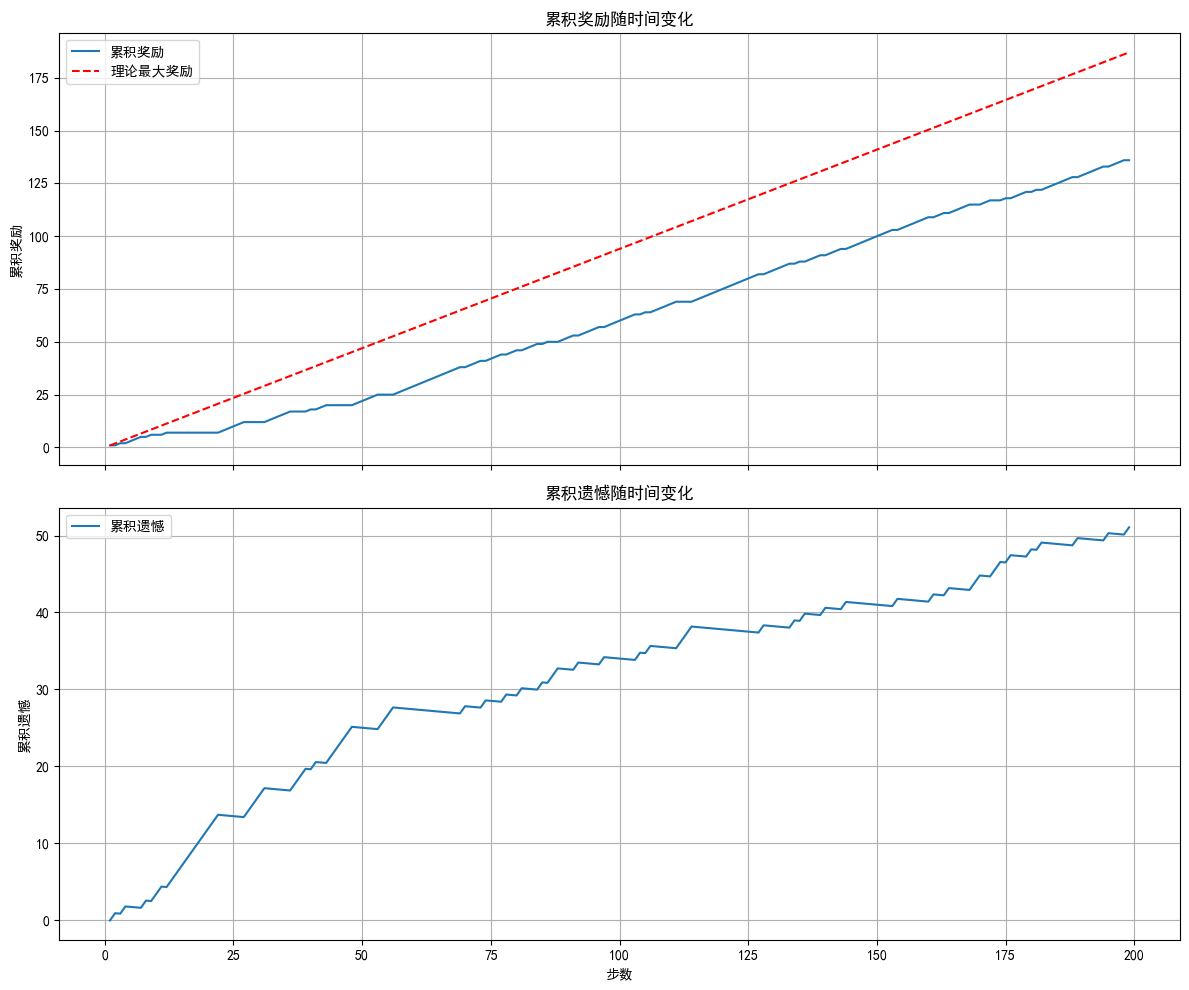

In [167]:
test_res_ep3[0].report_all() # 选择第1个异常情况来看看，你们可以自行换别的，大部分都差不多，我后面会证明的

真实奖励概率最高的1号拉杆只选了1次就再也没被选过:

Text(0.5, 1.0, '拉杆选择记录')

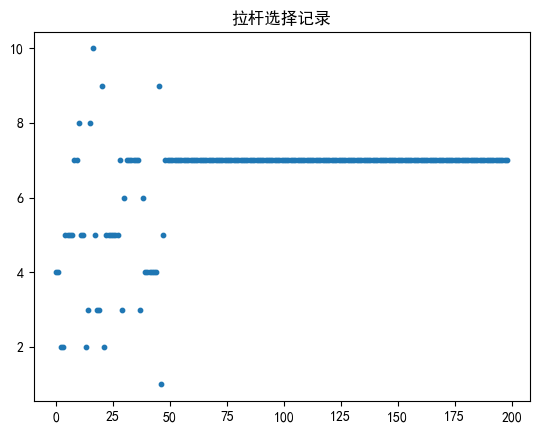

In [171]:
k_log = [x[0]+1 for x in test_res_ep3[0].history]
plt.scatter(range(len(k_log)), k_log, s=10)
plt.title('拉杆选择记录')

在此特殊情况中，最优拉杆（1号）的真实奖励概率虽然明显高于其他几个拉杆，但其运气不佳，前几次拉动算出的样本概率不如其他几个拉杆高，导致算法之后再也没有给它机会，最后被埋没，我们将这种算法漏洞擅自姑且命名为 **“和氏璧”漏洞**

注：和氏璧的典故是这样的，楚人卞和发现璞玉，先后献给楚厉王、楚武王，都被认为是石头而以欺君之罪砍去双脚。直到楚文王命人打磨，才发现是绝世美玉。


让我们来看看当前算法的结果中，累计遗憾超过45的异常样本里，有多少是由和氏璧漏洞引起的：

In [ ]:

def HeShiBi_error_stat(test_res):
    n = len(test_res)
    HeShiBi_error_counter = 0
    for i in range(n):
        k_best = test_res[i].best_idx
        if test_res[i].counts[k_best] < 10:
            HeShiBi_error_counter += 1
            print(f"第{i+1}个异常样本，最优拉杆{k_best}号被拉了{test_res[i].counts[k_best]}次")
    print("——"*20)
    print(f'共{n}个异常样本，其中由于和氏璧漏洞引起的共{HeShiBi_error_counter}例，占比{HeShiBi_error_counter/n:.2%}')

In [227]:
HeShiBi_error_stat(test_res_ep3)

第2个异常样本，最优拉杆1号被拉了2次
第4个异常样本，最优拉杆0号被拉了1次
第6个异常样本，最优拉杆5号被拉了3次
第7个异常样本，最优拉杆8号被拉了8次
第8个异常样本，最优拉杆6号被拉了9次
第9个异常样本，最优拉杆8号被拉了4次
第10个异常样本，最优拉杆2号被拉了1次
第11个异常样本，最优拉杆6号被拉了8次
第12个异常样本，最优拉杆6号被拉了9次
第15个异常样本，最优拉杆7号被拉了8次
第16个异常样本，最优拉杆3号被拉了2次
第23个异常样本，最优拉杆4号被拉了1次
第25个异常样本，最优拉杆3号被拉了7次
第26个异常样本，最优拉杆0号被拉了2次
第27个异常样本，最优拉杆1号被拉了9次
第30个异常样本，最优拉杆2号被拉了5次
第31个异常样本，最优拉杆5号被拉了6次
第33个异常样本，最优拉杆5号被拉了1次
第36个异常样本，最优拉杆2号被拉了3次
第37个异常样本，最优拉杆3号被拉了1次
第39个异常样本，最优拉杆1号被拉了1次
第40个异常样本，最优拉杆4号被拉了9次
第41个异常样本，最优拉杆2号被拉了2次
第42个异常样本，最优拉杆0号被拉了4次
第46个异常样本，最优拉杆6号被拉了0次
第47个异常样本，最优拉杆4号被拉了9次
第50个异常样本，最优拉杆9号被拉了8次
第51个异常样本，最优拉杆1号被拉了7次
第52个异常样本，最优拉杆2号被拉了1次
第55个异常样本，最优拉杆6号被拉了1次
第59个异常样本，最优拉杆1号被拉了2次
第60个异常样本，最优拉杆8号被拉了2次
第61个异常样本，最优拉杆2号被拉了5次
第62个异常样本，最优拉杆2号被拉了1次
第65个异常样本，最优拉杆1号被拉了1次
第66个异常样本，最优拉杆4号被拉了7次
第67个异常样本，最优拉杆8号被拉了4次
第70个异常样本，最优拉杆1号被拉了1次
第73个异常样本，最优拉杆8号被拉了9次
第75个异常样本，最优拉杆1号被拉了5次
第77个异常样本，最优拉杆0号被拉了6次
第78个异常样本，最优拉杆2号被拉了2次
第79个异常样本，最优拉杆7号被拉了4次
第81个异常样本，最优拉杆1号被拉了1次
第82个异常样本，最优拉杆4号被拉了7次
第83个异常样本，最优拉杆5号被拉了3次
第85个异常样本，最优拉杆8号被拉了1次
第89个异常样本，最优拉杆4号被拉了3

发现占比较大(51.27%)，所以要想解决累计遗憾异常大值的情况，可以首先从解决和氏璧漏洞入手

## 1.4 Ver4. 引入置信区间（置信度95%）

终于，我们得来点数学了（苍蝇搓掌）（苍蝇搓掌）

### 1.4.1 定义变量

**首先，我们定义以下参数变量：**

- $d$ 拉杆总数
- $p_k$ 第$k$个拉杆的实际概率，即'self.probs'里的对应值
- $\hat{p}_{k,i}$ 第$i$步时第$k$个拉杆的样本概率，即'self.values'里的对应值
- $m_{k,i}$ 第$i$步时第$k$个拉杆的累计拉动次数，即'self.counts'里的对应值
- $n$ 总步数，这里是200

**接着定义主变量：**

- $X_{k,i}$ 第$i$步时第$k$个拉杆的累计奖励次数

首先，注意到，由于你们生成 $p_k$ 的方式是'np.random.rand()'，是一个[0,1)上的均匀分布，且每个生成的$p_k$可以看作一个 i.i.d 样本，因此各个$p$的先验分布就是独立均匀分布，那其实在200次拉杆中任意一步里，如果还有从来没拉过的杆，那么这个杆的奖励概率$p_j \sim U(0,1)$，因此，各个拉杆之间确实是相互独立的，不存在相互影响，因此认为拉动各个拉杆为伯努利实验，故各个拉杆在被拉了 $m_{k,i}$ 次下由其产生的累计奖励数$X_{k,i}$ 服从二项分布，即

$$
\begin{align}
X_{k,i} \sim B(m_{k,i}, p_k)
\end{align}
$$


### 1.4.2 状态

接着，我们定义以下状态相关概念：

- 第$i$步的状态矩阵：
  
$$
\begin{align}
\begin{bmatrix}
\hat{p}_{1,i} & \cdots & \hat{p}_{d,i} \\
m_{1,i} & \cdots & m_{d,i} \\
\end{bmatrix}
\end{align}
$$

- 第$i$步时已尝试过的拉杆index构成的集合： $K_i^{(1)}$
- 第$i$步时还未尝试过的拉杆index构成的集合： $K_i^{(2)}$

**这些是在每一步里能直接获取的信息**

### 1.4.3 二向分布情况下的霍夫丁不等式

对于 $X \sim B(n, p)$，令 $\hat{p} = X/n$，则对任意 $\epsilon > 0$，有：

$$
\begin{aligned}
P(\hat{p} - p \geq \epsilon) &\leq \exp(-2n\epsilon^2) \\
P(|\hat{p} - p| \geq \epsilon) &\leq 2\exp(-2n\epsilon^2)
\end{aligned}
$$

该不等式定量地描述了二项分布经验频率 $\hat{p}$ 偏离其真实期望 $p$ 的概率上界，其表明，随着试验次数 $n$ 的增加，大偏差发生的概率以指数速度衰减，该不等式为我们之后的置信区间估计和泛化误差分析提供了理论基础。

根据上述不等式，有:
$$
\begin{align}
P(|\hat{p} - p| < \epsilon)  &= 1-P(|\hat{p} - p| \ge \epsilon) \\
&>  1 - 2\exp(-2n\epsilon^2)
\end{align}
$$

假设我们设定的置信度为 $1-\alpha$, 则令
$$1 - 2\exp(-2n\epsilon^2)= 1 - \alpha$$

解得：

$$
\begin{align}
\epsilon = \sqrt{\frac{1}{2n}(\ln2 - \ln \alpha)}
\end{align}
$$

则当$k$拉杆被拉了$n_k$次，当下其样本奖励概率为$\hat{p_k}$时，其实际奖励概率的“至少 $1-\alpha$ 置信区间”为：
$$
\begin{align}
[max(\hat{p_k} - \epsilon_k,0),\min(\hat{p_k} + \epsilon_k,1)]
\end{align}
$$
此处说“至少”的原因在于，$P(|\hat{p} - p| < \epsilon) > 1 - 2\exp(-2n\epsilon^2)$，$1 - 2\exp(-2n\epsilon^2)$ 为下限，我们处于谨慎和方便计算，就令下限等于置信度了。

在接下来的'extinction_statistician'算法中，我们仍然基于正反馈消退，若没得到奖励则换一个拉杆，但选择拉杆的方式和以往不一样，我们这次根据每个拉杆的样本概率 $1-\alpha$ 置信上限，选取值最大的拉杆。这样的话，注意到 $\epsilon_i$ 随  $n_i$ 增加而减小，则随着每个拉杆被拉动次数 $n_i$ 增长，其置信上限 $\hat{p_i} + \epsilon_i$ 会收缩，直到 $\hat{p_i}$ 趋于真实值 $p_i$，这样一来，<span style = 'color:red'>我们也就将拉动次数 $n_i$ 这个信息也纳入了决策考虑，提高了算法的信息利用率。</span>

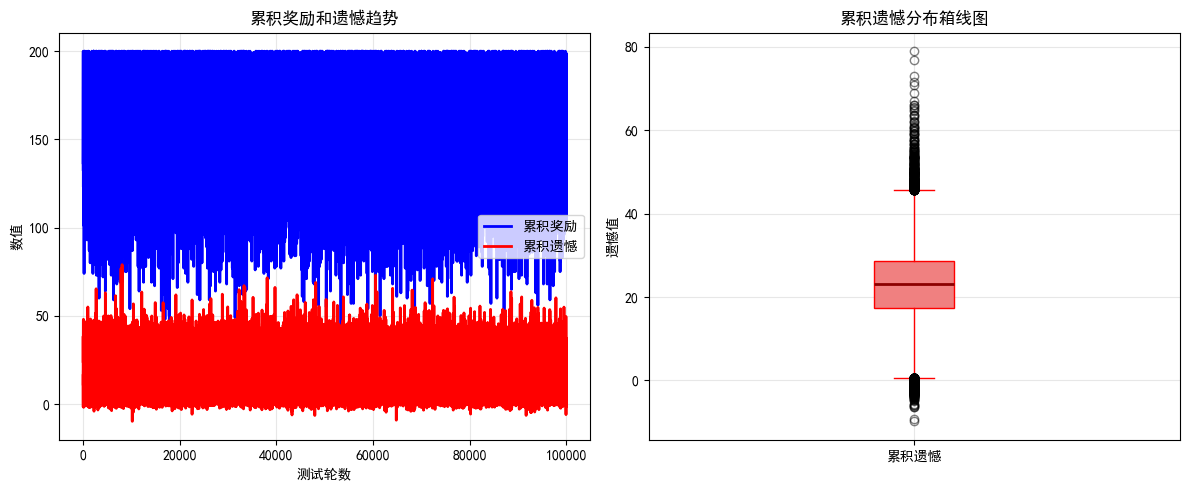

平均累积奖励: 158.97, 平均累积遗憾: 22.77
标准差(奖励): 19.62, 标准差(遗憾): 8.94
累积遗憾统计:
  最小值: -9.83, 最大值: 78.97
  25%分位数: 17.45
  中位数: 23.04
  75%分位数: 28.71


In [226]:
def extinction_statistician(bandit: object, num_itter: int= 200, alpha: float= 0.05, operation_log: bool= False):
    '''
    正反馈消退，消退后基于样本概率的95%置信上限选拉杆
    '''
    K = bandit.K
    reward = 0
    upper_bounds = np.zeros(K) # 各个拉杆的置信上限
    if operation_log:
        data_log = {i: [] for i in range(K)}
    for _ in range(num_itter):
        if not reward:
            if min(bandit.counts) < 3:
                k = np.argmin(bandit.counts)  # 如果存在累计拉动次数小于3的拉杆，则优先选择
            else:
                upper_bounds = np.minimum(np.array(np.round(bandit.values, 4)) + np.sqrt((0.69 - np.log(alpha)) / (2 * np.array(bandit.counts))), 1) # 更新置信上限
                if operation_log:
                    for i in range(K):
                        data_log[i].append(np.round(upper_bounds[i], 4)) # 记录置信上限，保留4位小数
                k = np.argmax(upper_bounds)  # 选择置信上限最大的拉杆
        reward = bandit.step(k)
    if operation_log:
        df_log = pd.DataFrame(data_log)
        df_log.plot(figsize=(12, 6), alpha=1)
        plt.title('各拉杆95%置信上限随拉动次数变化')
        plt.show()
    return bandit
test_res_es1 = test_strategy(extinction_statistician, anomalous_threshold=30)

从结果来看，虽然该算法的平均劣迹遗憾不是目前最小的，但<span style='color:red'>标准差首次突破10到了8.9 </span>，且根据上图“累计奖励和累计遗憾趋势”可以一眼看出，此算法的<span style='color:red'>异常值情况少了很多，最大累计遗憾为79.22，和前面几种算法的结果形成鲜明对比</span>。（喜）

In [228]:
HeShiBi_error_stat(test_res_es1)

第16个异常样本，最优拉杆9号被拉了8次
第17个异常样本，最优拉杆9号被拉了7次
第24个异常样本，最优拉杆8号被拉了8次
第42个异常样本，最优拉杆0号被拉了3次
第43个异常样本，最优拉杆8号被拉了4次
第55个异常样本，最优拉杆8号被拉了7次
第60个异常样本，最优拉杆9号被拉了4次
第75个异常样本，最优拉杆8号被拉了7次
第80个异常样本，最优拉杆7号被拉了4次
第94个异常样本，最优拉杆9号被拉了4次
第112个异常样本，最优拉杆9号被拉了7次
第130个异常样本，最优拉杆9号被拉了4次
第147个异常样本，最优拉杆1号被拉了8次
第149个异常样本，最优拉杆9号被拉了6次
第174个异常样本，最优拉杆9号被拉了9次
第185个异常样本，最优拉杆6号被拉了4次
第188个异常样本，最优拉杆9号被拉了8次
第194个异常样本，最优拉杆9号被拉了6次
第200个异常样本，最优拉杆8号被拉了3次
第201个异常样本，最优拉杆9号被拉了3次
第208个异常样本，最优拉杆5号被拉了8次
第212个异常样本，最优拉杆2号被拉了4次
第228个异常样本，最优拉杆8号被拉了4次
第238个异常样本，最优拉杆5号被拉了6次
第287个异常样本，最优拉杆7号被拉了4次
第298个异常样本，最优拉杆5号被拉了6次
第320个异常样本，最优拉杆5号被拉了6次
第322个异常样本，最优拉杆8号被拉了3次
第349个异常样本，最优拉杆9号被拉了3次
第370个异常样本，最优拉杆0号被拉了3次
第379个异常样本，最优拉杆8号被拉了4次
第394个异常样本，最优拉杆5号被拉了5次
第404个异常样本，最优拉杆6号被拉了4次
第435个异常样本，最优拉杆9号被拉了9次
第449个异常样本，最优拉杆4号被拉了7次
第461个异常样本，最优拉杆9号被拉了5次
第465个异常样本，最优拉杆7号被拉了3次
第466个异常样本，最优拉杆4号被拉了5次
第477个异常样本，最优拉杆8号被拉了9次
第492个异常样本，最优拉杆2号被拉了4次
第496个异常样本，最优拉杆4号被拉了5次
第517个异常样本，最优拉杆4号被拉了4次
第524个异常样本，最优拉杆7号被拉了7次
第536个异常样本，最优拉杆2号被拉了4次
第545个异常样本，最优拉杆4号被拉了6次
第549个异常样本，最优拉杆9号被拉了3

且更明显的，此时由于和氏璧漏洞引起的累计遗憾异常情况占比降到了<span style= 'color:red'>7.12%</span>，相比于之前的50%以上，效果可谓显著（喜）。

接下来让我们来看看剩下的那部分的累计遗憾异常是什么引起的，从异常情况里随机抽几个看看


累积奖励: 153.0
累积遗憾: 43.03
多臂老虎机统计结果:
 臂编号  选择次数   奖励概率   平均奖励
   1    86 0.8383 0.8488
   2     7 0.3279 0.4286
   3     3 0.1019 0.0000
   4     3 0.3121 0.0000
   5     3 0.1791 0.0000
   6     3 0.0531 0.0000
   7     3 0.0853 0.0000
   8    24 0.6903 0.7083
   9     6 0.3843 0.3333
  10    62 0.9802 0.9355


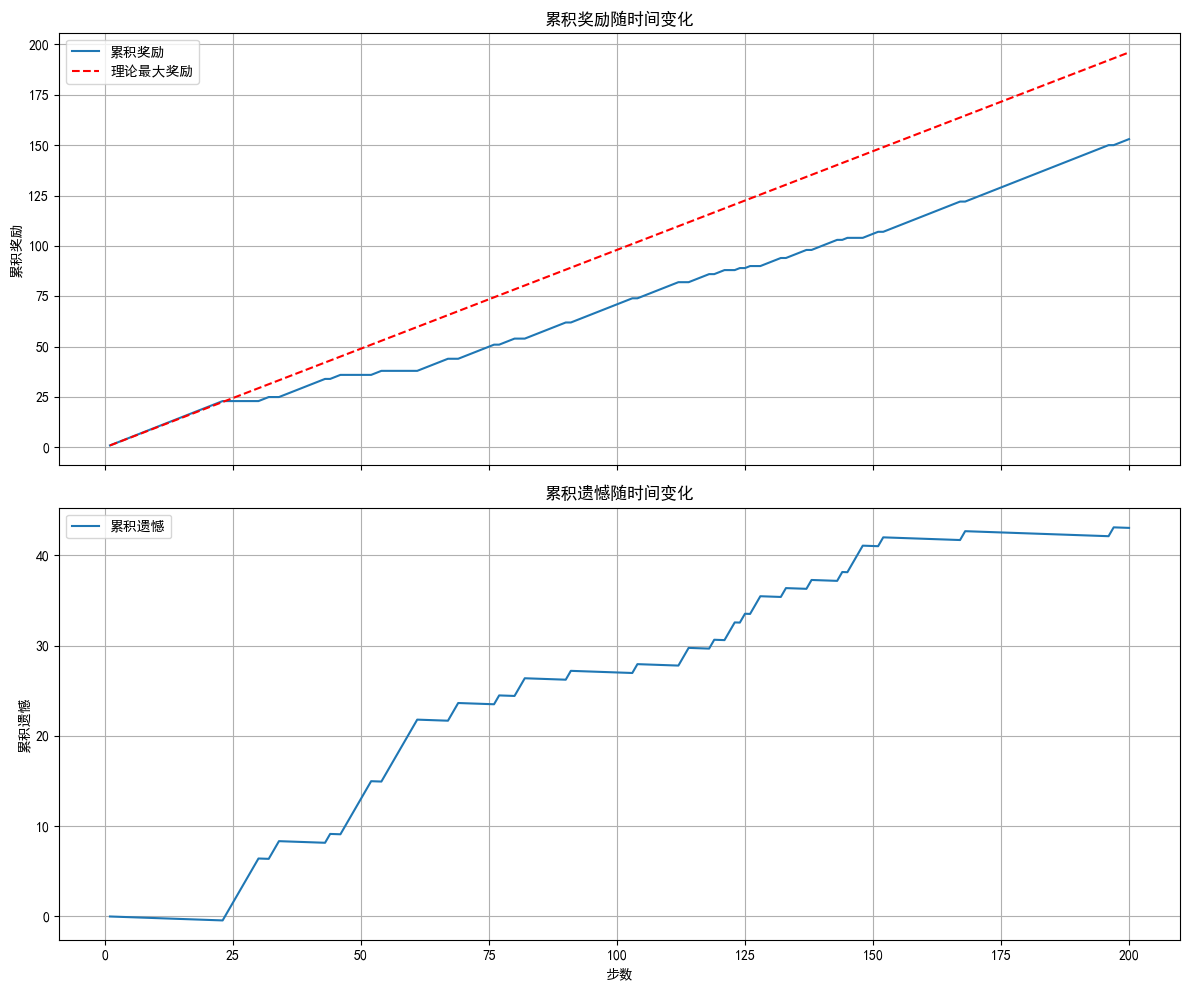

In [229]:
test_res_es1[np.random.choice(len(test_res_es1))].report_all()

研究后发现，

- 1. 目前的算法已经不会在实际奖励概率很低的拉杆上浪费时间，但在实际奖励概率相对较大的几个拉杆上徘徊不定。

- 2. <span style="color:red">**超过一半虽然都正确找到了真实奖励概率最大的拉杆，但由于前期用于探索的步数较多，导致了累计遗憾较大**</span>。关于超过一半都找到了最优拉杆的证明见下面程序结果：

In [187]:
def best_arm_found_stat(test_res):
    n = len(test_res)
    best_arm_found_counter = 0
    for i in range(n):
        if max(test_res[i].counts) == test_res[i].counts[test_res[i].best_idx]:
            best_arm_found_counter += 1
            print(f"第{i+1}个样本，最优拉杆{test_res[i].best_idx}号被找到")
    print("——"*20)
    print(f'共{n}个样本，其中找到最优拉杆的共{best_arm_found_counter}例，占比{best_arm_found_counter/n:.2%}')

In [230]:
best_arm_found_stat(test_res_es1)

第1个样本，最优拉杆4号被找到
第2个样本，最优拉杆9号被找到
第3个样本，最优拉杆9号被找到
第4个样本，最优拉杆5号被找到
第6个样本，最优拉杆9号被找到
第9个样本，最优拉杆1号被找到
第10个样本，最优拉杆2号被找到
第11个样本，最优拉杆3号被找到
第12个样本，最优拉杆1号被找到
第13个样本，最优拉杆6号被找到
第14个样本，最优拉杆0号被找到
第15个样本，最优拉杆9号被找到
第18个样本，最优拉杆9号被找到
第19个样本，最优拉杆5号被找到
第20个样本，最优拉杆2号被找到
第25个样本，最优拉杆8号被找到
第26个样本，最优拉杆7号被找到
第28个样本，最优拉杆5号被找到
第29个样本，最优拉杆4号被找到
第30个样本，最优拉杆7号被找到
第31个样本，最优拉杆7号被找到
第34个样本，最优拉杆9号被找到
第36个样本，最优拉杆4号被找到
第40个样本，最优拉杆1号被找到
第44个样本，最优拉杆1号被找到
第45个样本，最优拉杆9号被找到
第47个样本，最优拉杆2号被找到
第49个样本，最优拉杆9号被找到
第50个样本，最优拉杆4号被找到
第54个样本，最优拉杆4号被找到
第56个样本，最优拉杆5号被找到
第57个样本，最优拉杆0号被找到
第58个样本，最优拉杆4号被找到
第59个样本，最优拉杆4号被找到
第61个样本，最优拉杆8号被找到
第63个样本，最优拉杆9号被找到
第64个样本，最优拉杆6号被找到
第70个样本，最优拉杆0号被找到
第72个样本，最优拉杆3号被找到
第73个样本，最优拉杆0号被找到
第76个样本，最优拉杆4号被找到
第83个样本，最优拉杆4号被找到
第87个样本，最优拉杆7号被找到
第89个样本，最优拉杆9号被找到
第90个样本，最优拉杆8号被找到
第91个样本，最优拉杆4号被找到
第92个样本，最优拉杆6号被找到
第93个样本，最优拉杆6号被找到
第95个样本，最优拉杆9号被找到
第96个样本，最优拉杆8号被找到
第97个样本，最优拉杆0号被找到
第100个样本，最优拉杆1号被找到
第103个样本，最优拉杆6号被找到
第104个样本，最优拉杆0号被找到
第106个样本，最优拉杆5号被找到
第107个样本，最优拉杆9号被找到
第109个样本，最优拉杆7号被找到
第110个样本，最优拉杆6号被找到
第113个样本，最优拉杆7

可见，有58%的样本都找了最优拉杆。

<span style= 'color:red'>那么目前我们若想再降低均值，就得同时 “准确找到最优拉杆” 且 “尽快找到最优拉杆” ，或者再不行就在二者间找一个平衡</span>

## 1.5 Ver5. 调低置信水平

我们先试一下简单的办法，在准确性和速度上找一个平衡，把置信水平从95%调低一些，调到80%

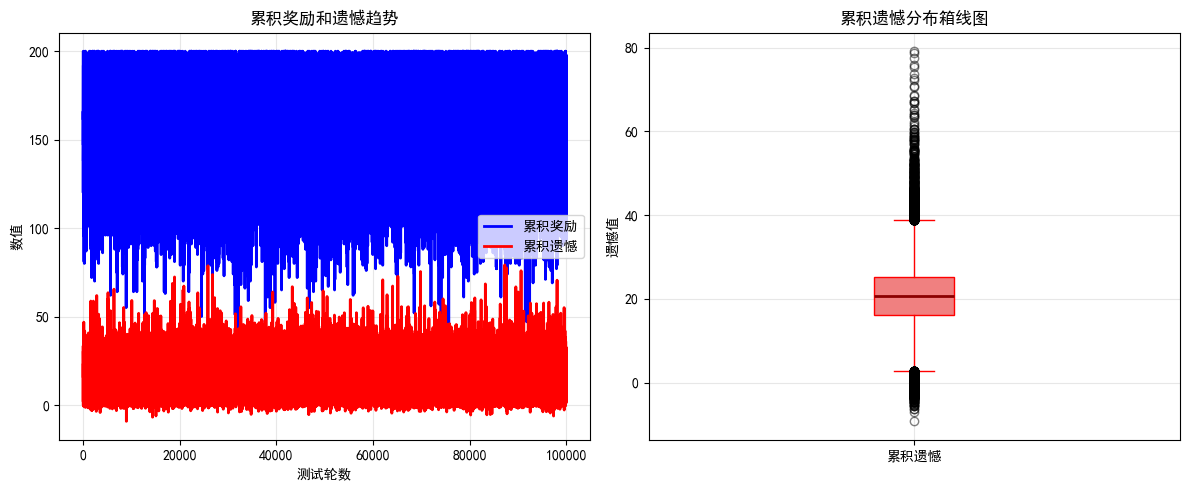

平均累积奖励: 161.47, 平均累积遗憾: 20.43
标准差(奖励): 18.94, 标准差(遗憾): 7.66
累积遗憾统计:
  最小值: -9.25, 最大值: 79.17
  25%分位数: 16.22
  中位数: 20.76
  75%分位数: 25.23


In [306]:
def extinction_statistician_v2(bandit: object, num_itter: int= 200, alpha: float= 0.2, operation_log: bool= False):
    '''
    正反馈消退，消退后基于样本概率的95%置信上限选拉杆
    '''
    K = bandit.K
    reward = 0
    upper_bounds = np.zeros(K) # 各个拉杆的置信上限
    if operation_log:
        data_log = {i: [] for i in range(K)}
    for _ in range(num_itter):
        if not reward:
            if min(bandit.counts) < 3:
                k = np.argmin(bandit.counts)  # 如果存在累计拉动次数小于3的拉杆，则优先选择
            else:
                upper_bounds = np.minimum(np.array(np.round(bandit.values, 4)) + np.sqrt((0.69 - np.log(alpha)) / (2 * np.array(bandit.counts))), 1) # 更新置信上限
                if operation_log:
                    for i in range(K):
                        data_log[i].append(np.round(upper_bounds[i], 4)) # 记录置信上限，保留4位小数
                k = np.argmax(upper_bounds)  # 选择置信上限最大的拉杆
        reward = bandit.step(k)
    if operation_log:
        df_log = pd.DataFrame(data_log)
        df_log.plot(figsize=(12, 6), alpha=1)
        plt.title('各拉杆80%置信上限随拉动次数变化')
        plt.show()
    return bandit
test_res_es2 = test_strategy(extinction_statistician_v2, anomalous_threshold=30)

**效果很明显，平均累计遗憾已经<span style= 'color:red'>下降到20档位</span>了，而标准差也<span style= 'color:red'>从8.9降到了7.66</span>，累计遗憾最大值为79**

<span style = 'color:skyblue'>另外，根据累计遗憾分布箱线图可以看出，调整置信度之后，__**累计遗憾的分布明显收缩**__，1,3分位值均明显向中位数靠拢，但0分位数值从95%置信度下的0上升到了3左右，这说明<u>调低置信度后一开始就找到最优拉杆的情况变少了</u>（这是坏事）；另外，4分位数从95%置信度下的40以上降到了约39，这说明<u>调低置信度后算法为了找到最优拉杆而耗费的次数变少了</u>（这是好事）。</span>， 加上分布中心向0靠近，这些因素相互对抗的结果是均值下降，标准差下降。

综上，目前要想进一步降低平均累计遗憾，有两个目标，一是让算法在保持当前找最优拉杆准确度的前提下减少为此耗费的步数，二是保持耗费步数不变的前提下提升找到最优拉杆的准确度，这里的关键点在于，要想提升找最优拉杆的准确度，就要获取更多信息，这会提升耗费步数，要想不这样就得想办法提高已知信息的利用率；要想加快找到算法自认为的最优拉杆的速度，也同样需要提升已知信息的利用率。所以，<span style= 'color:red'>提高已知信息利用率是突破口</span>，能一次优化两个目标。

我们上一次通过计算置信上限将$n_i$ 纳入了考量，提升了信息利用率，效果显著，<span style= 'color:red'>我们下一步优化算法的目标先确定为：提升已知信息的利用率</span>

In [304]:
def extinction_statistician_v2_manyplots(bandit: object, num_itter: int= 200, alpha: float= 0.2, operation_log: bool= False, plot_interval: int= 10):
    '''
    正反馈消退，消退后基于样本概率的80%置信上限选拉杆
    '''
    K = bandit.K
    reward = 0
    upper_bounds = np.zeros(K) # 各个拉杆的置信上限
    
    # 记录选择历史和数据
    choice_history = []  # 记录每次选择的拉杆
    reward_history = []  # 记录每次的奖励
    cumulative_rewards = []  # 记录累计奖励
    current_cumulative = 0
    
    # 记录每个拉杆的置信上限历史
    upper_bounds_history = {i: [] for i in range(K)}
    
    for t in range(num_itter):
        # 选择拉杆的逻辑
        if min(bandit.counts) < 3:
            k = np.argmin(bandit.counts)  # 如果存在累计拉动次数小于3的拉杆，则优先选择
        else:
            # 计算置信上限
            upper_bounds = np.minimum(
                np.array(bandit.values) + 
                np.sqrt((0.69 - np.log(alpha)) / (2 * np.array(bandit.counts))), 
                1
            )
            k = np.argmax(upper_bounds)  # 选择置信上限最大的拉杆
        
        reward = bandit.step(k)
        
        # 记录历史数据
        choice_history.append(k)
        reward_history.append(reward)
        current_cumulative += reward
        cumulative_rewards.append(current_cumulative)
        
        # 记录置信上限
        for i in range(K):
            if bandit.counts[i] > 0:
                current_upper_bound = min(
                    bandit.values[i] + np.sqrt((0.69 - np.log(alpha)) / (2 * bandit.counts[i])), 
                    1
                )
                upper_bounds_history[i].append(round(current_upper_bound, 4))
            else:
                upper_bounds_history[i].append(0)  # 如果还没有被选择过，记录为0
    
    # 最终统计信息和绘图
    if operation_log:
        # 创建最终结果图表
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 17))
        fig.suptitle('多臂老虎机算法执行结果', fontsize=14)
        
        # 图1：各拉杆置信上限变化
        for i in range(K):
            if len(upper_bounds_history[i]) > 0:
                ax1.plot(range(len(upper_bounds_history[i])), upper_bounds_history[i], 
                        label=f'拉杆 {i}', linewidth=2)
                # 标记真实概率
                ax1.axhline(y=bandit.probs[i], color=f'C{i}', linestyle='--', alpha=0.5, 
                           label=f'拉杆 {i} 真实概率 ({bandit.probs[i]:.3f})')

        ax1.set_title(f'各拉杆{1-alpha:.0%}置信上限变化')
        ax1.set_xlabel('步数')
        ax1.set_ylabel('置信上限')
        ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax1.grid(True, alpha=0.3)
        
        # 图2：拉杆选择分布
        choice_counts = [choice_history.count(i) for i in range(K)]
        bars = ax2.bar(range(K), choice_counts, color='skyblue', alpha=0.7)
        ax2.set_title('各拉杆被选择次数分布')
        ax2.set_xlabel('拉杆编号')
        ax2.set_ylabel('选择次数')
        
        # 在柱状图上显示数值
        for bar, count in zip(bars, choice_counts):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                    str(count), ha='center', va='bottom')
        
        # 图3：累计奖励变化
        ax3.plot(range(num_itter), cumulative_rewards, color='red', linewidth=2)
        ax3.set_title('累计奖励变化')
        ax3.set_xlabel('步数')
        ax3.set_ylabel('累计奖励')
        ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # 显示最终统计信息
        final_choice_counts = [choice_history.count(i) for i in range(K)]
        print("\n=== 算法执行结果统计 ===")
        for i in range(K):
            print(f"拉杆 {i}: 选择 {final_choice_counts[i]} 次, "
                  f"真实概率: {bandit.probs[i]:.3f}, 估计概率: {bandit.values[i]:.3f}")
        
        print(f"\n累计总奖励: {current_cumulative}")
        best_arm = np.argmax(bandit.probs)
        print(f"最佳拉杆编号: {best_arm} (概率: {bandit.probs[best_arm]:.3f})")
        print(f"最佳拉杆选择次数: {final_choice_counts[best_arm]}")
        print(f"最佳拉杆选择比例: {final_choice_counts[best_arm]/num_itter:.2%}")
        
        # 显示图表
        plt.show()
    
    return bandit




=== 算法执行结果统计 ===
拉杆 0: 选择 3 次, 真实概率: 0.127, 估计概率: 0.000
拉杆 1: 选择 3 次, 真实概率: 0.389, 估计概率: 0.333
拉杆 2: 选择 3 次, 真实概率: 0.039, 估计概率: 0.000
拉杆 3: 选择 3 次, 真实概率: 0.056, 估计概率: 0.000
拉杆 4: 选择 11 次, 真实概率: 0.693, 估计概率: 0.636
拉杆 5: 选择 6 次, 真实概率: 0.440, 估计概率: 0.500
拉杆 6: 选择 37 次, 真实概率: 0.828, 估计概率: 0.811
拉杆 7: 选择 71 次, 真实概率: 0.940, 估计概率: 0.887
拉杆 8: 选择 60 次, 真实概率: 0.795, 估计概率: 0.850
拉杆 9: 选择 3 次, 真实概率: 0.491, 估计概率: 0.000

累计总奖励: 155
最佳拉杆编号: 7 (概率: 0.940)
最佳拉杆选择次数: 71
最佳拉杆选择比例: 35.50%


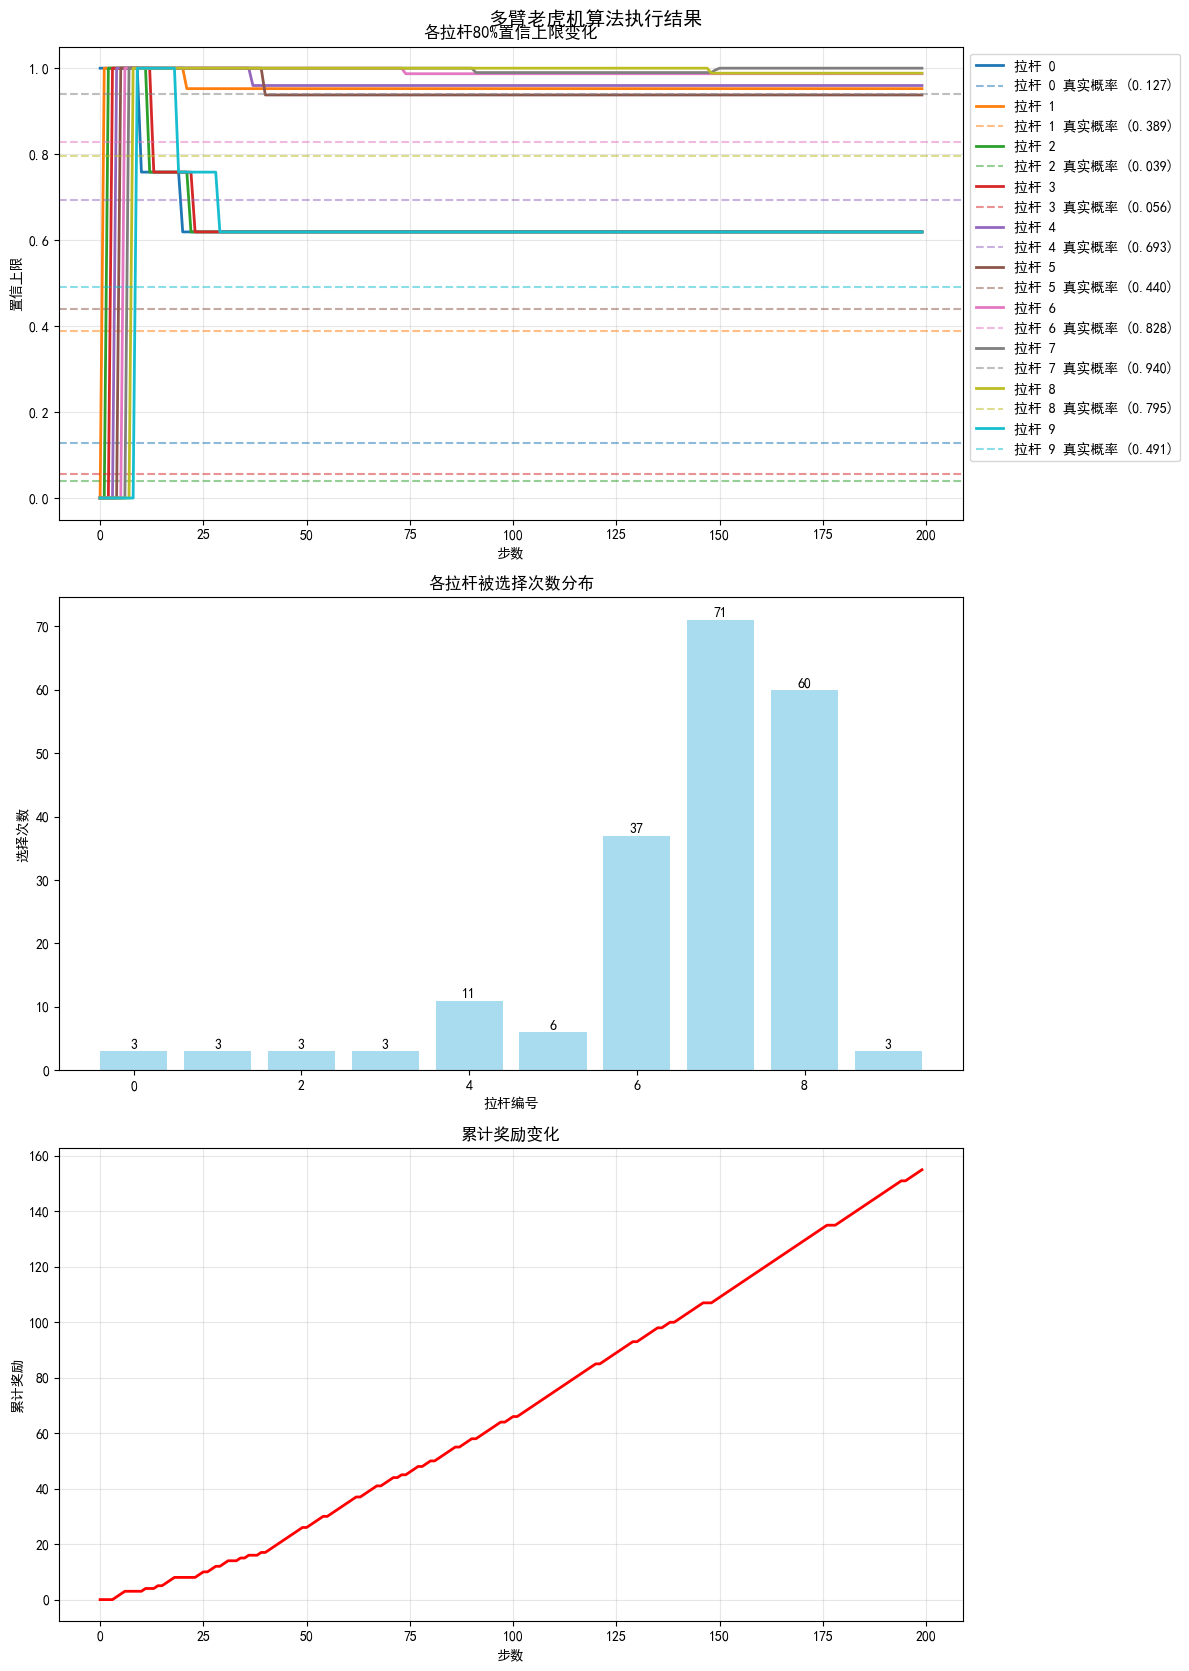


累积奖励: 155.0
累积遗憾: 32.97
多臂老虎机统计结果:
 臂编号  选择次数   奖励概率   平均奖励
   1     3 0.1272 0.0000
   2     3 0.3890 0.3333
   3     3 0.0393 0.0000
   4     3 0.0563 0.0000
   5    11 0.6928 0.6364
   6     6 0.4404 0.5000
   7    37 0.8284 0.8108
   8    71 0.9398 0.8873
   9    60 0.7950 0.8500
  10     3 0.4911 0.0000


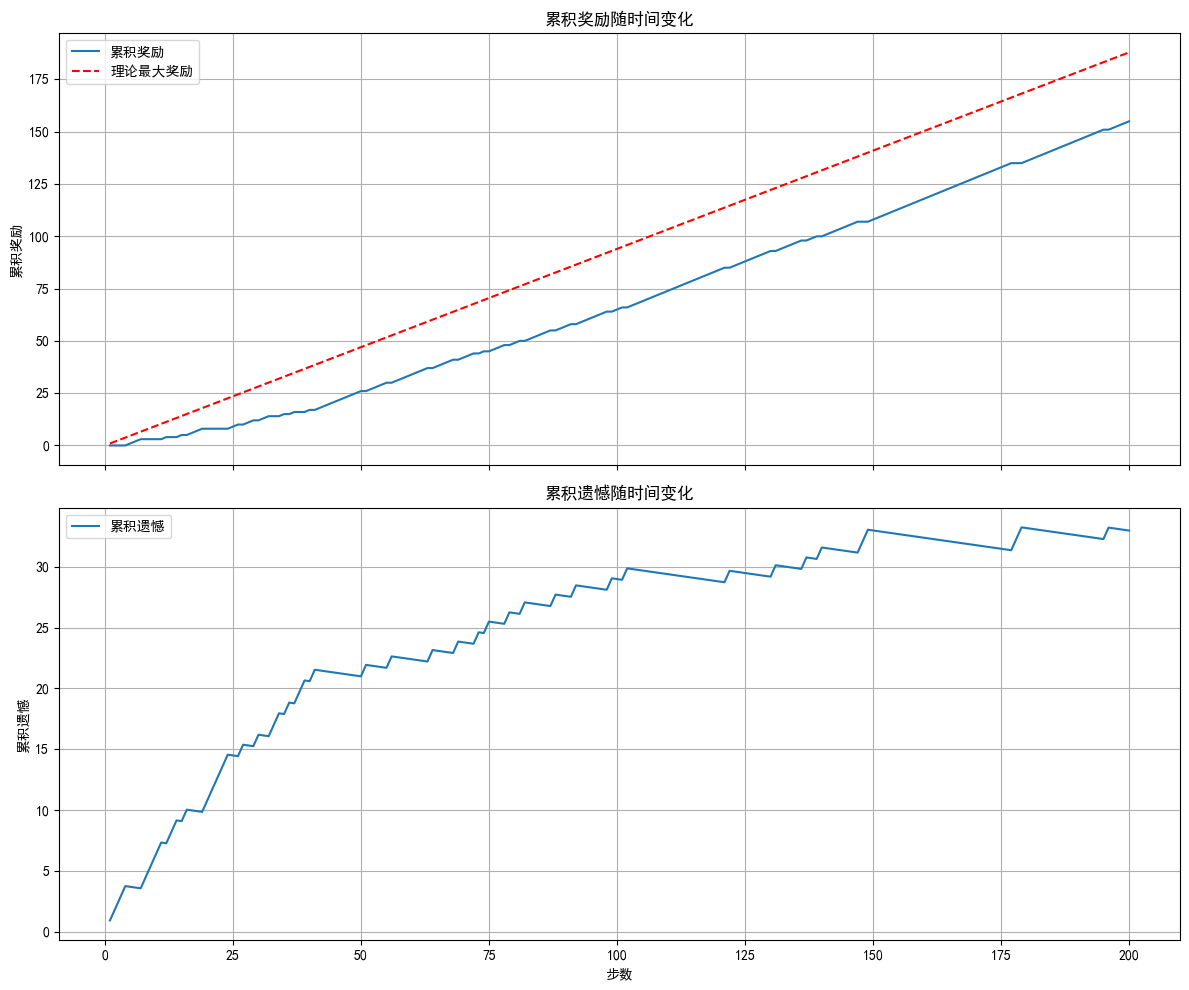

In [ ]:
extinction_statistician_v2_manyplots(BernoulliBandit(10), operation_log=True).report_all()

另外一个待解决的问题是这种多个拉杆都拉了很多次的情况，稀释了累计奖励，使得累计遗憾比较大

## Ver.6 引入连续获得奖励次数

In [236]:
np.argsort([0.1,0,1, 0.3, 0.2, 0.5, 0.4])

array([1, 0, 4, 3, 6, 5, 2], dtype=int64)

In [257]:
def extinction_statistician_v3(bandit: object, num_itter: int= 200, alpha: float= 0.2, operation_log: bool= False):
    '''
    正反馈消退，消退后基于样本概率的80%置信上限以及平均连续获得奖励次数选拉杆
    '''
    K = bandit.K
    reward = 0

    # 置信上限的初始化
    upper_bounds = np.zeros(K) # 各个拉杆的置信上限
    if operation_log:
        data_log = {i: [] for i in range(K)}

    # 连续奖励次数的初始化
    multiple_reward_counts = np.array([0]*K)  # 各个拉杆的累计连续成功次数, 只要中断就归零
    multiple_reward_counts_log = [[] for _ in range(K)]  # 各个拉杆的历史累计连续成功次数记录
    for _ in range(num_itter):
        if not reward:
            if min(bandit.counts) < 3:
                k = np.argmin(bandit.counts)  # 如果存在累计拉动次数小于3的拉杆，则优先选择
            else:
                # 置信上限部分
                upper_bounds = np.minimum(np.array(np.round(bandit.values, 4)) + np.sqrt((0.69 - np.log(alpha)) / (2 * np.array(bandit.counts))), 1) # 更新置信上限
                if operation_log:
                    for i in range(K):
                        data_log[i].append(np.round(upper_bounds[i], 4)) # 记录置信上限，保留4位小数

                # 连续奖励次数部分
                if multiple_reward_counts[k] > 3:
                    multiple_reward_counts_log[k].append(multiple_reward_counts[k])
                    multiple_reward_counts[k] = 0  # 重置对应拉杆的连续奖励计数
                # 计算各拉杆的平均连续奖励次数
                avg_multiple_reward_counts = np.array([np.sum(multiple_reward_counts_log[i])/bandit.counts[i] if multiple_reward_counts_log[i] else 0 for i in range(K)])
                # 计算综合得分为置信上限排名+平均连续奖励次数排名,都是数值越大排名数越大
                scores = upper_bounds + 0.05 * np.argsort(avg_multiple_reward_counts)


                k = np.argmax(scores)  # 选择得分最高的拉杆

        reward = bandit.step(k)
    if operation_log:
        df_log = pd.DataFrame(data_log)
        df_log.plot(figsize=(12, 6), alpha=1)
        plt.title('各拉杆95%置信上限随拉动次数变化')
        plt.show()
    return bandit

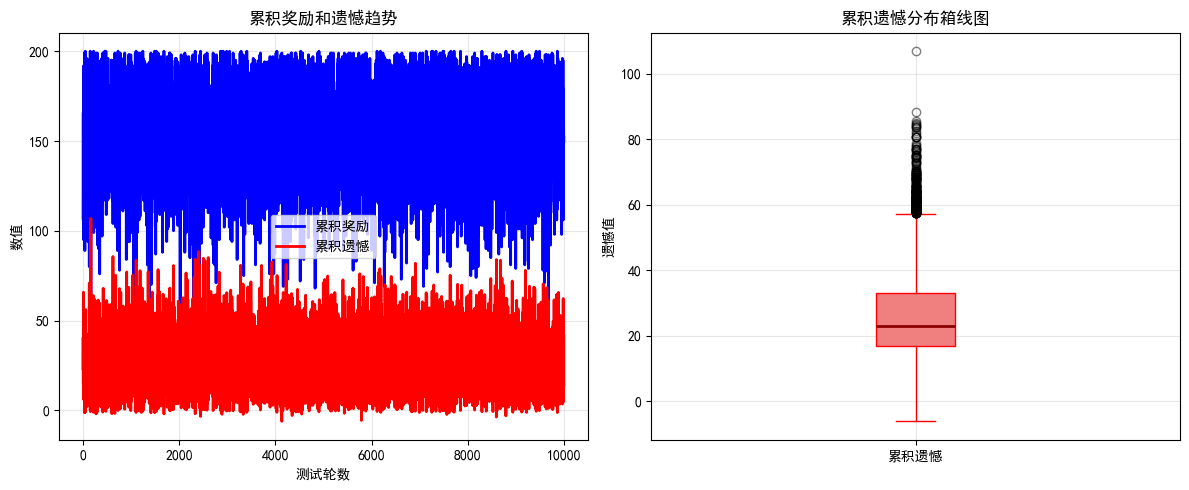

平均累积奖励: 156.37, 平均累积遗憾: 25.65
标准差(奖励): 21.75, 标准差(遗憾): 13.79
累积遗憾统计:
  最小值: -6.11, 最大值: 106.86
  25%分位数: 16.78
  中位数: 23.13
  75%分位数: 33.00


In [301]:
test_res_es3 = test_strategy(extinction_statistician_v3, 10000, anomalous_threshold=30)

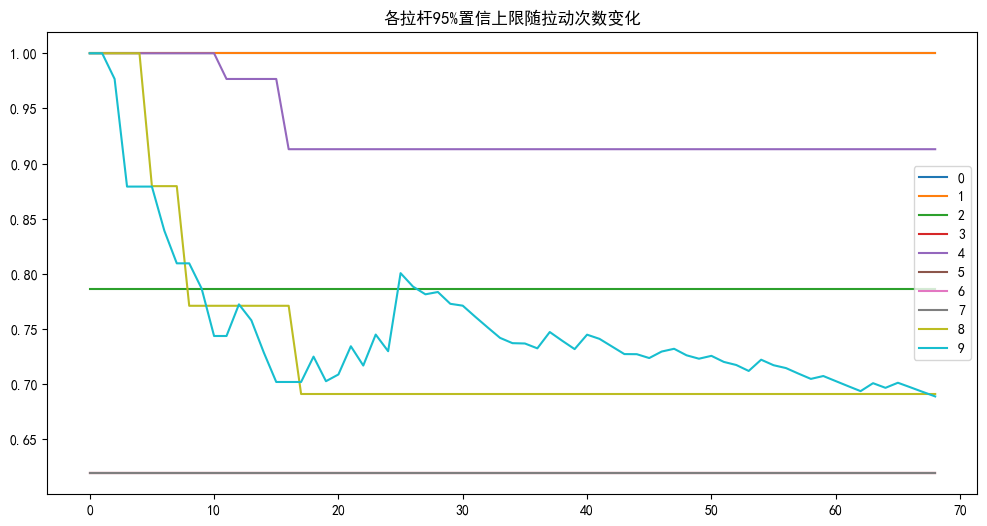


累积奖励: 109.0
累积遗憾: 54.52
多臂老虎机统计结果:
 臂编号  选择次数   奖励概率   平均奖励
   1     4 0.8176 0.5000
   2     4 0.7902 0.5000
   3     4 0.3688 0.2500
   4     3 0.3080 0.0000
   5     9 0.5993 0.5556
   6     3 0.5282 0.0000
   7     3 0.5668 0.0000
   8     3 0.2198 0.0000
   9     7 0.2542 0.2857
  10   160 0.6080 0.6062


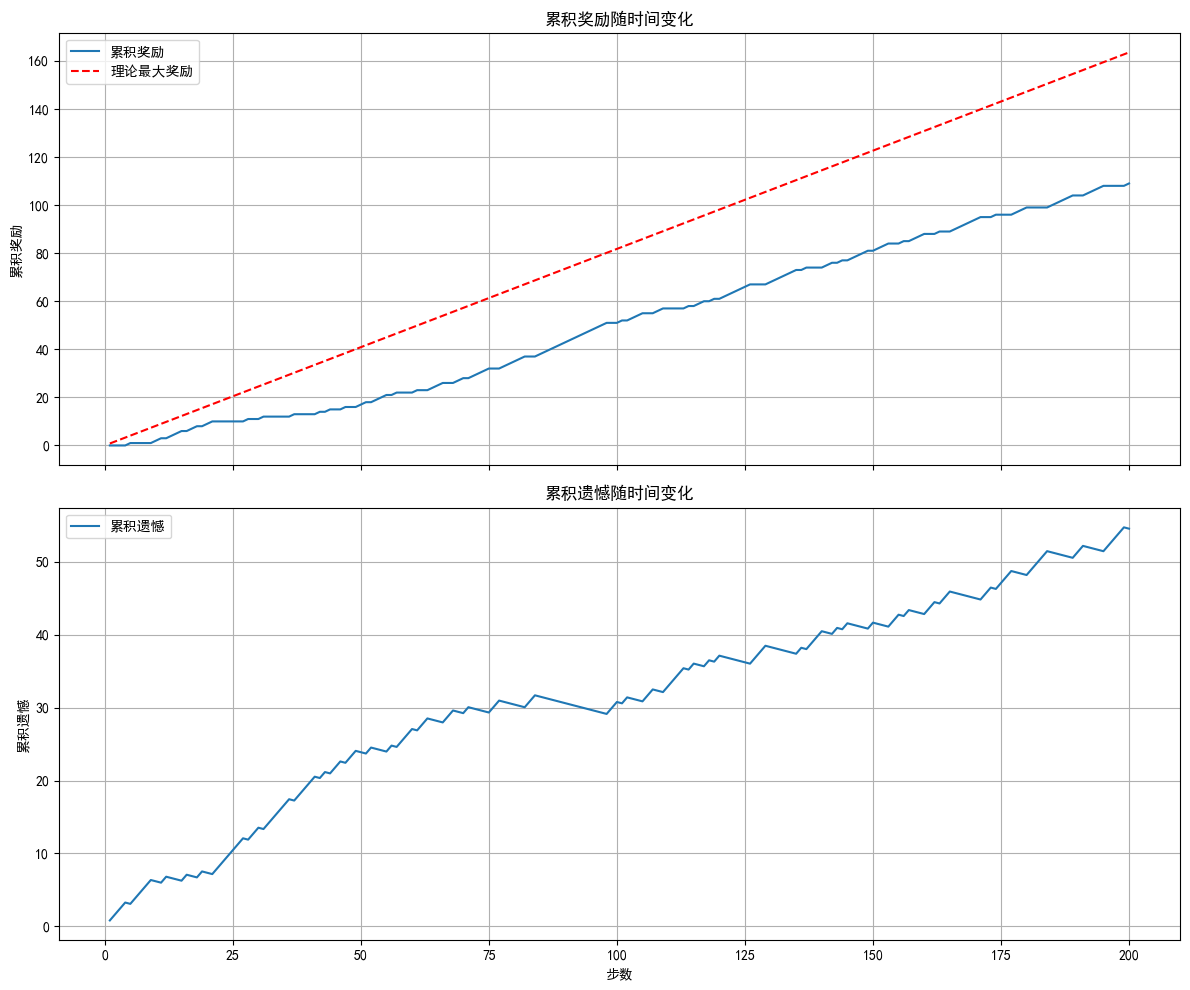

In [263]:
test_bandit_es3 = extinction_statistician_v3(BernoulliBandit(10), operation_log=True)
test_bandit_es3.report_all()

目前还是存在一些问题，时间来不及了，但我认为只要能够恰当地将连续获得奖励次数引入决策考量，就能使得算法在一些特定情况下更快速确定最优臂，之后会继续研究。

# 2. 还没弄完的方案B 边际利润决策算法


这个游戏另外一种思路是，需要用尽可能少的探索步数找到实际奖励概率尽可能大的拉杆，然后就盯死那个拉杆拉就完事儿了，从而实现整体奖励最大化。但是就有一个矛盾点：如果探索步数太少了，那每个拉杆的样本概率可能和实际概率出入有点大，容易找了一个实际概率其实没那么大的拉杆一直拉了；而如果探索步数太多了，有可能在一些实际概率低的拉杆上浪费步数，那又亏了，所以我们要在其中找到一个微妙的平衡点，在什么条件下停止探索然后盯死一个拉杆一直拉，这是我们接下来要用数学来解决的问题。

## 2.1 定义变量

首先，我们定义以下参数变量：

- $d$ 拉杆总数
- $q_k$ 第$k$个拉杆的样本概率，即'self.values'里的对应值
- $p_k$ 第$k$个拉杆的实际概率，即'self.probs'里的对应值
- $m_k$ 第$k$个拉杆的累计拉动次数，即'self.counts'里的对应值
- $n$ 总步数，这里是200

接着，我们定义以下状态相关概念：

- 第$i$步的状态矩阵：
  
$$
\begin{align}
\begin{bmatrix}
q_1 & \cdots & q_d \\
m_1 & \cdots & m_d \\
\end{bmatrix}
\end{align}
$$

- 第$i$步时已尝试过的拉杆index构成的集合： $K_i^{(1)}$
- 第$i$步时还未尝试过的拉杆index构成的集合： $K_i^{(2)}$


每次状态转移需要进行的决策是：是保持当前所选拉杆还是换别的，如果换别的，是换$K_i^{(1)}$里的还是换$K_i^{(2)}$里的。这里面有一个“诱惑”和“机会成本”的权衡，找到实际概率更大的拉杆是换拉杆的“诱惑”，其机会成本就是要放弃当前样本期望收入为$\max\limits_{k \in K_i^{(1)}}(q_{k,i})$的拉杆。

我们来对上述涉及概率论的东西进行一个算的计：


## 2.2 探索新拉杆的收益

<span style="color:skyblue">**省流：已知$K_1$集合中拉杆的样本概率和拉杆次数前提下，$K_2$集合中拉杆的实际先验分布为相互独立的均匀分布，因此在200次拉杆中只要$K_2$非空，那么新拉杆的实际奖励概率就一定服从$p_j \sim U(0,1)$，那么探索新拉杆的收益期望一定固定为$\mathbb{E}[p_j]=0.5$**</span>，以下具体数学推导请不用太在意，而且其实有更简单的证明路径，我当时没反应过来。

首先，注意到，由于你们生成 $p_k$ 的方式是'np.random.rand()'，是一个[0,1)上的均匀分布，且每个生成的$p_k$可以看作一个 i.i.d 样本，因此各个$p$的先验分布就是独立均匀分布，那其实在200次拉杆中任意一步里，如果还有从来没拉过的杆，那么这个杆的奖励概率$p_j \sim U(0,1)$

In [ ]:
min([np.random.rand() for _ in range(100)])

0.015137444500084696

In [ ]:
max([np.random.rand() for _ in range(100)])

0.9989192530454544

因此，探索新的拉杆的期望收益可表示为:

对于任意$i$，若$K_{i}^{(2)} \ne \empty$，则对于任意$j \in K_2$：

$$
\begin{align}
\mathbb{E}[p_j | q_{k,i}, m_{k,i} ~~\text{for}~~ k\in K_i^{(1)}] = \int_{0}^1 p \cdot 1 \,d\,p = 0.5
\end{align}
$$

另外再看看条件概率吧，主打一个来都来了:


在第$i$步，对于任意未探索拉杆$j\in K_2$, 探索新拉杆发现任意更大获奖概率的可能性$P_{ij}$为

$$
\begin{align}
P_{ij} &=
P(p_j > \max\limits_{k \in K_i^{(1)}} (p_k) \,| q_{k,i}, m_{k,i} ~~\text{for}~~ k\in K_i^{(1)}) \\
&= 1 - \max\limits_{k \in K_i^{(1)}} (p_k) 
\end{align}
$$

第二个等式成立的原因是各个$p$的先验分布都是独立均匀分布


在第$i$步，对于任意未探索拉杆$j\in K_2$, 探索新拉杆发现更大获奖概率，且获奖概率为$p$的概率密度函数$P_{ij}(p)$为

$$
\begin{align}
P_{ij}(p) &=
P(p_j = p  \,| q_{k,i}, m_{k,i} ~~\text{for}~~ k\in K_i^{(1)},p_j > \max\limits_{k \in K_i^{(1)}} (p_k)) \\
&= \frac{P(p_j = p  > \max\limits_{k \in K_i^{(1)}} (p_k) \,| q_{k,i}, m_{k,i} ~~\text{for}~~ k\in K_i^{(1)}) }{P(p_j > \max\limits_{k \in K_i^{(1)}} (p_k) \,| q_{k,i}, m_{k,i} ~~\text{for}~~ k\in K_i^{(1)})} \\
&= \frac{P(p_j = p  > \max\limits_{k \in K_i^{(1)}} (p_k) \,| q_{k,i}, m_{k,i} ~~\text{for}~~ k\in K_i^{(1)}) }{P_{ij}} \\
\end{align}
$$


则，在第$i$步，对于任意未探索拉杆$j\in K_2$, 探索新拉杆发现的这个更大获奖概率的数学期望为

$$
\begin{align}
\mathbb{E}[p_j | p_j > \max\limits_{k \in K_i^{(1)}} (p_k)，q_{k,i}, m_{k,i} ~~\text{for}~~ k\in K_i^{(1)}] &= 
\int_{ \max\limits_{k \in K_i^{(1)}} (p_k)}^1 p\cdot P_{ij}(p) \,d\,p \\
&= \frac{1}{P_{ij}}\int_{ \max\limits_{k \in K_i^{(1)}} (p_k)}^1 p\cdot \tilde{P}_{ij}(p)  \,d\,p \\
\end{align}
$$

其中，
$$
\begin{align}
\tilde{P}_{ij}(p)  &:= P(p_j = p \,| q_{k,i}, m_{k,i} ~~\text{for}~~ k\in K_i^{(1)}) \\

\end{align}
$$

因为是独立均匀分布，所以有

$$\begin{align}
\tilde{P}_{ij}(p) = P(p_j = p) = 1
\end{align}
$$

（注意这里是概率密度函数，不是概率）

那么此时我们可以对之前那个条件期望做一个化简了
$$
\begin{align}
\mathbb{E}[p_j | p_j > \max\limits_{k \in K_i^{(1)}} (p_k)，q_{k,i}, m_{k,i} ~~\text{for}~~ k\in K_i^{(1)}]
&= \frac{1}{P_{ij}}\int_{ \max\limits_{k \in K_i^{(1)}} (p_k)}^1 p\cdot \tilde{P}_{ij}(p)  \,d\,p \\
&=  \frac{1}{P_{ij}}\int_{ \max\limits_{k \in K_i^{(1)}} (p_k)}^1 p\cdot 1   \\
&= \frac{1}{2P_{ij}}\left( 1 - \max\limits_{k \in K_i^{(1)}} (p_k)^2\right)  \\
&= \frac{1}{2}\left( 1 + \max\limits_{k \in K_i^{(1)}} (p_k)\right)  \\
\end{align}

$$

算那么多其实就是个截断均匀分布，绷不住就对了, 我先蚌埠住

那个0.5肯定不是说发现一个拉杆的样本概率超过0.5就一直只拉这个杆了，而是根据新拉杆的预估样本概率来评价该杆是否存在实际概率大于目前为止最大样本概率杆的可能

## 2.3 探索新拉杆的机会成本

新拉杆

In [ ]:
def extinction_player_v4(bandit: object, iter_num: int, verbose: bool = False) -> object:
    '''
    正反馈消退算法，消退后基于样本概率选拉杆，但是要顾及大数定律，然后打擂台赛

    :param: bandit: 初始化好的老虎机
    :param: iter_num： 总共要拉多少次

    '''
    bandit_copy = copy.deepcopy(bandit)
    K = bandit_copy.K
    reward = 0
    success_counts = np.array([0]*K)  # 成功次数
    fail_counts = np.array([0]*K)     # 失败次数
    candidate_arms_mask = np.array([1]*K) # 可能的最优臂集合
    max_continuous_success_counts = np.array([0]*K)  # 当前连续成功次数
    ring = [] # 擂台
    for _ in range(0, iter_num):
        if not reward:
            continuous_success_counter = 0 # 重置连续成功计数器
            if min(bandit_copy.counts) <= 0 : # 保证每个拉杆至少被拉一次
                k = np.random.choice(np.where(candidate_arms_mask == 1)[0])
            else:
                # k = np.argmax(np.array(bandit_copy.values)*candidate_arms_mask)
                # k = np.argmax(bandit_copy.values)
                k = np.argmax(max_continuous_success_counts / 100 + np.array(bandit_copy.values)) # 优先选择最大连续成功次数多的
            # k = np.random.choice(np.where(candidate_arms_mask == 1)[0])
        reward = bandit_copy.step(k)
        success_counts[k] += reward
        fail_counts[k] += (1 - reward)
        if reward:
            continuous_success_counter += 1
            max_continuous_success_counts[k] = max(max_continuous_success_counts[k], continuous_success_counter)
        try:
            k_challenger = list(success_counts*candidate_arms_mask).index(5)
            if k_challenger not in ring:
                ring.append(k_challenger)
        except ValueError:
            pass
        try: 
            k_challenger = list(fail_counts*candidate_arms_mask).index(5)
            if k_challenger not in ring:
                ring.append(k_challenger)
        except ValueError:
            pass
        if len(ring) >= 2:
            k_loser = ring[0] if bandit_copy.values[ring[0]] <= bandit_copy.values[ring[1]] else ring[1]
            ring.remove(k_loser)
            candidate_arms_mask[k_loser] = 0
            if verbose:
                print(f"淘汰了{k_loser+1}号拉杆")
                print(f'最大连续成功次数: {max_continuous_success_counts}')
    print(f'最大连续成功次数: {max_continuous_success_counts}')
    return bandit_copy
test_strategy(bandit, extinction_player_v4, 10000)

In [ ]:
def extinction_player_v5(bandit: object, iter_num: int, verbose: bool = False) -> object:
    '''
    正反馈消退算法，消退后基于每个拉杆的得分选拉杆，然后打擂台赛。得分按照每个拉杆的平均连续成功次数和样本概率加权计算

    :param: bandit: 初始化好的老虎机
    :param: iter_num： 总共要拉多少次

    '''
    bandit_copy = copy.deepcopy(bandit)
    K = bandit_copy.K
    reward = 0
    success_counts = np.array([0]*K)  # 成功次数
    fail_counts = np.array([0]*K)     # 失败次数
    candidate_arms_mask = np.array([1]*K) # 可能的最优臂集合
    continuous_success_counts = [[] for _ in range(K)]  # 当前连续成功次数
    continuous_success_counter = 0 # 当前连续成功计数器
    ring = [] # 擂台
    for _ in range(0, iter_num):
        if not reward:
            if continuous_success_counter >= 2:
                continuous_success_counts[k].append(continuous_success_counter)
            continuous_success_counter = 0 # 重置连续成功计数器
            if min(bandit_copy.counts) <= 0 : # 保证每个拉杆至少被拉一次
                k = np.random.choice(np.where(candidate_arms_mask == 1)[0])
            else:
                # k = np.argmax(np.array(bandit_copy.values)*candidate_arms_mask)
                # k = np.argmax(bandit_copy.values)
                k = np.argmax(np.array([np.mean(x) for x in continuous_success_counts])/100 + np.array(bandit_copy.values)) # 优先选择最大连续成功次数多的
            # k = np.random.choice(np.where(candidate_arms_mask == 1)[0])
        reward = bandit_copy.step(k)
        success_counts[k] += reward
        fail_counts[k] += (1 - reward)
        if reward:
            continuous_success_counter += 1
        try:
            k_challenger = list(success_counts*candidate_arms_mask).index(5)
            if k_challenger not in ring:
                ring.append(k_challenger)
        except ValueError:
            pass
        try: 
            k_challenger = list(fail_counts*candidate_arms_mask).index(5)
            if k_challenger not in ring:
                ring.append(k_challenger)
        except ValueError:
            pass
        if len(ring) >= 2:
            k_loser = ring[0] if bandit_copy.values[ring[0]] <= bandit_copy.values[ring[1]] else ring[1]
            ring.remove(k_loser)
            candidate_arms_mask[k_loser] = 0
            if verbose:
                print(f"淘汰了{k_loser+1}号拉杆")
                print(f'连续成功次数: {continuous_success_counts}')
    print(f'平均连续成功次数: {[np.mean(x) for x in continuous_success_counts if len(x) > 0]}')
    return bandit_copy
test_strategy(bandit, extinction_player_v5, 10000)